# Finding Patterns in Top Financial Analysts' Predictions:  <br> the Study of a Large Collection of Research Reports

<b>Alessandro Alviani </b> <br>
<i>School of Mathematics, Computer Science and Engineering <br>
City, University of London </i>

______________________________________________________________________________________________________________________

# I. Table of contents 

<b>1. Importing and previewing the dataframes </b>

    1.1. Reports 
    1.2. References

<b>2. Working on a map for the tickers</b>

    2.1. Approach
    2.2. Final map
   
<b>3. Scraping the companies' close values</b>
        
    3.1. Close values scraper
    3.2. Adjusting the research reports' target prices by stock splits
    
<b>4. Scraping the companies' ESG values </b>
        
    4.1. ESG values scraper
    
<b>5. Exploratory data analysis (EDA) and Data Cleaning </b>

    5.1. Missing Values
        5.1.1. Dropping missing values
    5.2. Mapping columns values to more distinguishable names 
    5.3. Duplicate values
        5.3.1. Dropping duplicate values
    5.4. Outliers 
        5.4.1. Dealing with 0 or next to 0 values in the stock prices predictions
        5.4.2. Market Capitalization
        5.4.3. Country
        5.4.4. Sector and Industry
        5.4.5. Market Capitalization Size
        5.4.6. ESG values
    
<b>6. Scraping other close values  </b>
       
      6.1. Close values scraper
    
<b>7. Feature derivation </b>
      
      7.1 Prediction results
      
<b>8. Data Analysis </b>

    8.1. Question 1: Can analysts that perform significantly better than others be identified? 
        8.1.1. Results
    8.2. Question 2: Do features such as industry, country or company size influence the accuracy of  the ratings received?
        8.2.1. Industry
        8.2.2. Sector
        8.2.3. Country
        8.2.4. Clustering
        8.2.4. Results
    8.3. Insights on ratings and providers  
        8.3.1. WordCloud
        8.3.2. Ratings
        8.3.3. Providers 
        8.3.4. Results
    8.4. Question 3: Is there any correlation between ESG values and analysts’ ratings?
        8.4.1. Boxplots and colormpas
        8.4.2. Effect size - Cohen's d
        8.4.3. Results
        
    8.5. Are forecasts influenced by specific external events?
        8.5.1. Work with time series
        8.5.2. Results
        
<b>9. Conclusions </b> 
   
    9.1. Final conclusions
    9.2. Future work

______________________________________________________________________________________________________________________

# Import libraries

In [16]:
# all imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf # Yahoo Finance scraper. Source: https://github.com/ranaroussi/yfinance
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from kmodes.kmodes import KModes
from sklearn import preprocessing
import prince # Multiple Correspondence Analysis (MCA)
from dython.nominal import associations # categorical associations (correlation matrix)
import scipy.stats as stats
sns.set_style('white') # sets the plots' style

# 1. Import and preview the dataframes

In [17]:
reports = pd.read_csv("research_report_data_all.csv"); # import the research reports csv
references = pd.read_csv("equity_reference_data_all.csv"); # import all the company references csv

The <i> "reports" </i> dataframe contained all the research reports' main features. These are the predictions made by the analysts on future stock prices. <br> The <i> "references" </i> dataframe contained all the companies' references. These are the companies' details.

In [18]:
print("Reports shape = {}" .format(reports.shape)) # checks the dataframe dimensions
reports.head(2)

Reports shape = (277886, 10)


row                    research_report_id  \
0    0  be63b063-c7fe-4d59-9001-97591ae0eed9   
1    1  ebe52f37-4e85-412d-bcf4-01a527cf262a   

                   research_provider_id                        lead_author_id  \
0  47898792-7a28-4914-b991-2bb17d8fb85a  232091e9-3688-46bd-8073-c05c6a13d54e   
1  47898792-7a28-4914-b991-2bb17d8fb85a  b63255fe-4005-476a-a800-70eb4428acfd   

     symbol                              research_report_title  \
0  GRF/P SM  Grifols SA (B Share) "FVIII decline could be w...   
1   1209 HK  China Resources Mixc Lifestyle Services "UBS E...   

  research_rating research_publish_date research_target_date  \
0             BUY            2018-09-13           2019-09-13   
1             BUY            2020-12-09           2021-12-09   

   research_target_price  
0                   22.5  
1                   35.2

### Quick overview on dimensions and unique values for the reports

In [28]:
# print the number of unique values for every column in reports - useful to get a quick overview on the data
for column in reports.select_dtypes(include='object').columns:
    print(f'Number of {column} unique values = {reports[column].nunique()}')

Number of research_report_id unique values = 277886
Number of research_provider_id unique values = 7
Number of lead_author_id unique values = 1961
Number of symbol unique values = 12903
Number of research_report_title unique values = 253875
Number of research_rating unique values = 4
Number of research_publish_date unique values = 3308
Number of research_target_date unique values = 3305


In [29]:
print("References shape = {}" .format(references.shape)) # checks the dataframe dimensions
references.head(2)

References shape = (64341, 10)


row identifier   symbol           name country currency  \
0    0   HBF2Y3-R  0R7T LN  TINC Comm. VA      GB      EUR   
1    1   GGYZZM-R  ULVR CP   Unilever PLC      CZ      CZK   

                  sector                 industry  market_cap_bn  \
0                Finance      Investment Managers   5.434419e+05   
1  Consumer Non-Durables  Household/Personal Care   1.475415e+08   

  market_cap_classification  
0                 Small Cap  
1                 Large Cap

### Quick overview on dimensions and unique values for the references

In [30]:
# print the number of unique values for every column in references
for column in references.select_dtypes(include='object').columns:
    print(f'Number of {column} unique values = {references[column].nunique()}')

Number of identifier unique values = 64341
Number of symbol unique values = 62999
Number of name unique values = 54961
Number of country unique values = 94
Number of currency unique values = 73
Number of sector unique values = 21
Number of industry unique values = 132
Number of market_cap_classification unique values = 6


## First task - Tickers
The data was originally collected from different sources (mainly Bloomberg) which used different companies'symbols (tickers) standards. <br> There were 12,903 unique symbols in the research reports that had to be linked to the references' and made Yahoo Finance (YF) compatible. 

### Trying to merge the tickers as they were

In [31]:
# merge reports and references
merged = pd.merge(reports, references, on = 'symbol', how = 'left') # left merge on reports (on the tickers)
print('Shape of the resulting dataframe after merging = {} '.format(merged.shape))

Shape of the resulting dataframe after merging = (277886, 19) 


As expected from a left merge the dimensions stayed consistent with the <i> reports </i> dataframe's but...

In [32]:
# find missing values in the merged dataframe and count how many labels don't have corresponding data (labels that didn't match between the two frames)
merged_null = merged[merged.isnull().any(axis=1)]
print('Number of unique labels not matching between the datasets = {}'.format(len(merged_null.symbol.unique()))) 

Number of unique labels not matching between the datasets = 6283


... the tickers' loss was substantial: 6,283 symbols (nearly 50% of the labels) didn't match and generated nulls.

# 2. Working on a map for the tickers

This proved to be harder than expected. The tickers had to match between <i> reports </i> and <i> references </i> but ultimately match with the symbols in YF as well. More "aggressive" mappings between the original dataframes resulted in better merges but bigger losses when trying to scrape YF. More "generic" maps got worse merges but worked better with YF. <br> The best solution, time aside, would have been to create two different maps: <br> option 1: one for each dataframe and both towards YF, <br> option 2: one from <i> references </i> towards <i> reports </i> and then from <i> reports </i> towards YF. 


## 2a. Approach
This work was very time consuming and due to time limitations a hybrid solution was implemented. <br> A first map was created based on the most evident differences between <i> reports </i>, <i> references </i> and the main patterns in the YF tickers' system. The map was then applied to both dataframes and tested on the merge and on the scrape. Tickers that bounced back from YF were stored in a list of "missed tickers" and then used to re-improve the map. Each new map was applied to both dataframes, tested on the merge and used to scrape YF again. During the scraping (which was a slow process) the bounced tickers were printed to screen to make possible studying them "on the fly", before the loop had terminated some hours later.
<br> Below the code for getting the tickers from YF, after a map had been applied.

In [39]:
#convert the symbols to a string data type 
references['symbol'] = references['symbol'].astype(str)
reports['symbol'] = reports['symbol'].astype(str)
# use the map on both frames 
%run yahoo_ticker_mapping #find this map in the folder: yahoo_ticker_mapping.py
references['symbol'] = references.symbol.apply(map_to_yahoo_tickers);
reports['symbol'] = reports.symbol.apply(map_to_yahoo_tickers);

In [38]:
#Get the ticker labels and store the good ones and missed ones in two lists.
counter = 0
missed_tickers = []  # tickers to fix
good_tickers = []  # good tickers

symbols = reports.symbol.unique()
tickers = [yf.Ticker(symbol) for symbol in symbols] # scrape the tickers. Original source: https://github.com/ranaroussi/yfinance
for ticker in tickers:
    counter += 1
    print("Loop number = {}".format(counter))  # print counter (useful to show where we are)
    try:
        good_tickers.append(ticker.info['symbol'])  # append the good tickers.
    except KeyError:
        missed_tickers.append(ticker)    # append the ticker not found.
        print("Missed_ticker = {} ".format(ticker))  
    except TypeError: 
        missed_tickers.append(ticker)    # append the ticker not found.
        print("Missed_ticker = {} ".format(ticker))  

The above loop takes a few hours to complete. (Reminder: it was 12,903 unique companies).

In [ ]:
# two lists with the good and bad tickers were always saved to csv and analysed in excel as well (useful to take a quick glance at all of them).
# pd.DataFrame(missed_tickers).to_csv('missed_tickers.csv')
# pd.DataFrame(good_tickers).to_csv('good_tickers.csv')

It took several hours to improve the mapping, but from an initial merge generating 6,283 mismatching labels between the original datasets and 0% compatibility with YF it was obtained a merge resulting in 3,072 mismatching labels and 70% YF compatibility. 

In [40]:
frame = pd.merge(reports, references, on = 'symbol', how = 'left')
print('Shape of the resulting dataframe after merging = {} '.format(frame.shape)) 

Shape of the resulting dataframe after merging = (277908, 19) 


In [41]:
frame_null = frame[frame.isnull().any(axis=1)]
print('Number of unique labels not matching between the datasets = {}'.format(len(frame_null.symbol.unique())))

Number of unique labels not matching between the datasets = 3072


Note: some labels were "wrong" to begin with and the data went as far back as to 2011, lapse of time in which several companies were delisted, so some loss was inevitable. <br> Out of a total of 12903 unique symbols, in the end "only" 3072 were lost. <br> All the unique labels that required manual labelling were identified. Manual labelling could have saved 500 to 1000 additional labels (estimated) but it was beyond the scope of this project.

## 2b. Final map 

Below the final map applied to the datarames' symbols:

In [ ]:
#.AB, .CB, .EY, .IB, .MK, .SJ, are "random" unique labels that would require manual labelling one by one.
yahoo_exchange_mapping = {  # dictionary of symbols
    "AV": "VI",
    "AU": "AX",
    "BB": "BR",
    "BZ": "SA",
    "CN": "TO",
    "SW": "SW",
    "CH": "SZ",
    "CI": "SN",
    "CS":"SZ",
    "CP":"PR",
    "DC": "CO",
    "FH": "HE",
    "FP": "PA",
    "GR": "DE",
    "GY":"DE",
    "HK":"HK",
    "ID": "IR",
    "IM": "MI",
    "IN":"NS",
    "IJ":"JK",
    "IT":"TA",
    "LN": "L",
    "KS":"KQ",
    "JP": "T",
    "JT": "T",
    "MM": "MX",
    "NA": "AS",
    "NO": "OL",
    "PW": "WA",
    "PL": "LS",
    "RO": "IL",
    "SM": "MC",
    "SS": "ST",
    "SP": "SI",
    "TI": "IS",
    "TB":"BK",
    "TT": "TW",
    "US": "",
    "SJ": "JO",
    "SZ":"SS",
    "VX":"SW",}

def map_to_yahoo_tickers(string): # function that prepares the strings and applies the previous map to them
    '''
    Returns a symbol string in a Yahoo Finance compatible format.
    '''
    string = string.replace('@', '.')
    string = string.replace('-NYSE', "")
    string = string.replace('-NSDQ', "")
    string = string.replace(' EQUITY', "") # these 4 line (3 above) get rid of common suffixes
    symbol, _, exchange = string.partition(" ") # the following 2 lines split the strings and symbols in 3 (prefix, join, suffix)
    base_symbol, _, share_class = symbol.partition("/")
    yahoo_exchange = yahoo_exchange_mapping.get(exchange, exchange) # prepares the "parts" of the symbol and applies them (up until end of function)
    yahoo_symbol = base_symbol
    if share_class != "":
        yahoo_symbol = "-".join([yahoo_symbol, share_class])
    if yahoo_exchange != "":
        yahoo_symbol = ".".join([yahoo_symbol, yahoo_exchange])
    if (len(yahoo_symbol) == 6) & (".HK" in yahoo_symbol): # add zeros to the Honk Hong stocks
        yahoo_symbol = '0'+ yahoo_symbol
    if (len(yahoo_symbol) == 5) & (".HK" in yahoo_symbol):
        yahoo_symbol = '00'+ yahoo_symbol
    return yahoo_symbol

# 3. Scraping the close values

<i> Reports </i> and <i> references </i>were merged in <i> "frame" </i> (with the mapped tickers).

In [ ]:
#convert the symbols to a string data type 
references['symbol'] = references['symbol'].astype(str)
reports['symbol'] = reports['symbol'].astype(str)
# use the map on both frames 
%run yahoo_ticker_mapping #find this map in the folder: yahoo_ticker_mapping.py
references['symbol'] = references.symbol.apply(map_to_yahoo_tickers);
reports['symbol'] = reports.symbol.apply(map_to_yahoo_tickers);
frame = pd.merge(reports, references, on = 'symbol', how = 'left')

In [42]:
frame.head(2)

row_x                    research_report_id  \
0      0  be63b063-c7fe-4d59-9001-97591ae0eed9   
1      1  ebe52f37-4e85-412d-bcf4-01a527cf262a   

                   research_provider_id                        lead_author_id  \
0  47898792-7a28-4914-b991-2bb17d8fb85a  232091e9-3688-46bd-8073-c05c6a13d54e   
1  47898792-7a28-4914-b991-2bb17d8fb85a  b63255fe-4005-476a-a800-70eb4428acfd   

     symbol                              research_report_title  \
0  GRF-P.MC  Grifols SA (B Share) "FVIII decline could be w...   
1   1209.HK  China Resources Mixc Lifestyle Services "UBS E...   

  research_rating research_publish_date research_target_date  \
0             BUY            2018-09-13           2019-09-13   
1             BUY            2020-12-09           2021-12-09   

   research_target_price    row_y identifier  \
0                   22.5  11375.0   LFHL6Z-R   
1                   35.2  35676.0   BKPD4X-R   

                                           name country currency  \
0                    Grifols, S.A. Pref Class B      ES      EUR   
1  China Resources Mixc Lifestyle Services Ltd.      HK      HKD   

              sector                 industry  market_cap_bn  \
0  Health Technology   Pharmaceuticals: Major   3.774418e+06   
1            Finance  Real Estate Development   1.217759e+07   

  market_cap_classification  
0                   Mid Cap  
1                 Large Cap

At this stage the <i> frame </i> had research reports and companies' references, which was plenty of data, but not very useful in this form.  <br> At least having the companies' close values was needed. This would have allowed to check them against the predictions and start "classifying" the reports as "right" or "wrong". <br> The following code did that:

## 3a. Scraper 

In [ ]:
list_of_frames = [] # stores the frames in a list
counter = 0

for ticker in frame.symbol.unique():
    counter += 1
    print('loop number {}'.format(counter))   
    to_merge = frame.loc[frame.symbol == ticker]   # the following 5 lines extract each company from the main dataframe and save it into a new dataframe, organized to be merged later.
    to_merge['Date'] = pd.to_datetime(to_merge['research_target_date']) # sets the research target date as index
    to_merge.set_index('Date', inplace=True)
    to_merge = to_merge.sort_index(ascending=True)
    to_merge['Close'] = np.NaN # creates the close column (useful for the merge)
    try:
        yfticker = yf.download(ticker, start = '2011-01-01', end = '2021-10-01', interval = '1d', Threads = False, groupby = 'ticker')  # this is the scraper. Original source: https://github.com/ranaroussi/yfinance   
        dframe = pd.DataFrame(yfticker.Close.reset_index()) # the following 3 lines create a dataframe with the close values for the ticker scraped.
        dframe['symbol'] = ticker
        dframe.set_index('Date', inplace=True)
        merged = pd.merge_asof(to_merge, dframe, by = 'symbol', left_index = True, right_index=True, direction = 'nearest' )  # the previous frames are merged here.
        list_of_frames.append(merged)
    except KeyError:
        print('error')  # exceptions deal with errors mostly due to companies not found.
    except TypeError: 
        print('error')  
    except ValueError: 
        print('error')

The above code, one at the time, extracts each company (and all its reports) from the main dataframe and stores it in a new dataframe, specific to that company. Then it scrapes that company's close values from YF and stores them in a dataframe. The two dataframes are then merged together and the resulting one is appended to a list of frames. <br> This list of frames (one per company)  is concatenated at the end. Code below:

In [ ]:
all_frames = pd.concat(list_of_frames) # concatenates all the dataframes that were previously stored in the list.

Note: Looking at this augmented frame it was noticed that a large number of predictions were very far from the close values and sometimes from each others as well. The Team at Upside Technologies explained that companies undergo stock splits (can also be reverse splits) and that any analyst' prediction before a certain stock split needs to be updated by that split. More specifically, research reports' target prices need to be divided by the product of the split factors of all splits  occurred after the reports target prices published date (this is company specific). <br>
Stock splits can be scraped from Yahoo Finance with the code below:  

In [2]:
yf.Ticker('AAPL').get_splits() # stock split at different time "windows".

Date
1987-06-16    2.0
2000-06-21    2.0
2005-02-28    2.0
2014-06-09    7.0
2020-08-31    4.0
Name: Stock Splits, dtype: float64

## 3b. Adjusting the predictions by stock splits

The code below scrapes stock splits from Yahoo Finance and updates the research reports target prices on the fly.

In [ ]:
companies_not_found = [] # Missed labels were gathered again to try and improve the mapping.
counter = 0
all_frames.research_publish_date = pd.to_datetime(all_frames.research_publish_date) 
for ticker in all_frames.symbol.unique():
    counter += 1
    print('loop number {}'.format(counter)) # counter, useful to show the progress.
    try:
        split = pd.DataFrame(yf.Ticker(ticker).get_splits())  # download the stock splits
        split = split['Stock Splits'][::-1].cumprod() # invert (order from past to present) the frame and calculates the cumulative products
        if split.shape[0] == 0: # if there have not been stock splits for that company, continue
            continue
        for i in range(len(split)):    
            if i == len(split) -1:    # this if handles instances in which there's only been one split.
                time = split.index[len(split)-1]
                locator = (all_frames.symbol == ticker) & (all_frames.research_publish_date < time) # locates company and right dates
                all_frames.loc[locator, ['research_target_price']] = (all_frames[locator].research_target_price)/float(split.values[len(split)-1]) #loc assignment - locates the right research target prices and modifies them inplace
            else:
                time_upbound =  split.index[i]  # the following two lines create the time windows to apply the splits to - when more than one stock split every prediction occurred between a split and the next one. It's important to centre them.
                time_lowbound = split.index[i+1]
                locator = (all_frames.symbol == ticker) & (all_frames.research_publish_date < time_upbound) & (all_frames.research_publish_date > time_lowbound)             
                all_frames.loc[locator, ['research_target_price']] = (all_frames[locator].research_target_price)/float(split.values[i])
    except KeyError:    
            companies_not_found.append(ticker)   # exceptions are mostly due to missing stock splits
    except ValueError:     
            companies_not_found.append(ticker)

The above code scrapes the stock splits for each company and calculates their cumulative product at each time "window" (windows can be taught as the times between one split and the next one). Then it locates a company in the main frame (<i> all_frames </i>) and adjusts the analysts' predictions by dividing them by the cumulative product of all the splits occurred in the time windows that followed that prediction.

# 4. Scraping the ESG values

At this point the main frame (<i> all_frames </i>) contained references, reports (with adjusted predictions) and close values. To gather even more data it was decided to scrape the companies' ESG values, for as many companies as possible. It was known that these were "recent" indicators and many companies still didn't have one but it could not be known how many and it was agreed it'd be still interesting to try and fetch that information. <br> Below the code to scrape ESG values for a company. Similarly to the loop used to scrape the close values, these values were saved in a list and then concatenated.

## 4a. Scraper

In [ ]:
list_of_esg = []
for ticker in all_frames.symbol.unique():
    counter += 1
    print('loop number {}'.format(counter))   
    try:
        esg = yf.Ticker(ticker).get_sustainability()    # ESG scraper. Original source: https://github.com/ranaroussi/yfinance   
        esg = esg.T   
        esg['symbol'] = ticker  # Add the symbol (useful to the merge later on). 
        list_of_esg.append(esg)  # Creates a list of frames 
    except KeyError:
        print('error')   # Missing tickers generate a few errors that are handled with except. 
    except TypeError: 
        print('error')  
    except ValueError: 
        print('error')
    except AttributeError: 
        print('error')

# 5. EDA and Data Cleaning

In [45]:
yf.Ticker('AAPL').get_sustainability().T  # .T transpose the frame from long to wide. yf original source: https://github.com/ranaroussi/yfinance   

2021-9 palmOil controversialWeapons gambling socialScore nuclear furLeather  \
Value    False                False    False        7.99   False      False   

2021-9 alcoholic    gmo catholic socialPercentile  ... esgPerformance   coal  \
Value      False  False    False             None  ...     UNDER_PERF  False   

2021-9 pesticides  adult percentile            peerGroup smallArms  \
Value       False  False      13.68  Technology Hardware     False   

2021-9 environmentScore governancePercentile militaryContract  
Value              0.29                 None            False  

[1 rows x 27 columns]

The above was the longest loop in this work. It took from 7AM to 10PM to complete and in the end the ESG values for "only" about 50% of the total companies were found. <br> Below the ESG frames are concatenated and the resulting one is merged to the main frame.

In [ ]:
esg = pd.concat(list_of_esg) # frame containing all esg values
all_frames_esg = pd.merge(all_frames, esg, how = 'left', on = 'symbol') # merge the previous main frame (all_frames) with the esg into a new frame

In [51]:
all_frames_esg.shape

(219802, 46)

Lastly, all the rows after 10.10.2021 (time of the work) were dropped. Since the data was very recent and analysts make predictions at 12 month, this was about one year worth of predictions (all the predictions made in 2021 on 2022). <br> Code below:

In [52]:
all_frames_esg.set_index('research_target_date', inplace=True)
all_frames_esg.index = pd.to_datetime(all_frames_esg.index)
final_frame = all_frames_esg['2012-06-12' : '2021-10-10'] #saves the frame containing reports + references + close values + ESG (for the select dates) into the final one "final_frame".

final_frame  =  reports + references + close values + ESG  <br> (from 12-06-2012 to 10-10-2021)

In [ ]:
#final_frame.to_csv('final_frame.csv') -- commented out to avoid repeated savings

In [54]:
final_frame.shape

(167277, 46)

In [19]:
final_frame = pd.read_csv('final_frame.csv')
final_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167277 entries, 0 to 167276
Data columns (total 46 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date                       167277 non-null  object 
 1   research_report_id         167277 non-null  object 
 2   research_provider_id       167277 non-null  object 
 3   lead_author_id             167277 non-null  object 
 4   symbol                     167277 non-null  object 
 5   research_rating            167277 non-null  object 
 6   research_publish_date      167277 non-null  object 
 7   research_target_date       167277 non-null  object 
 8   research_target_price      167277 non-null  float64
 9   actual_close               167267 non-null  float64
 10  research_report_title      167277 non-null  object 
 11  identifier                 162734 non-null  object 
 12  name                       162734 non-null  object 
 13  country                    16

## 5.1. Missing Values
Below a quick view on the missing values:

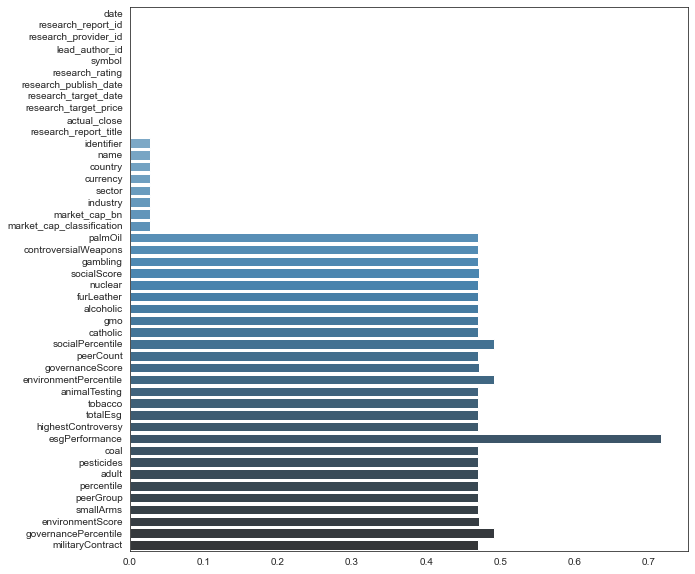

In [92]:
fig, ax = plt.subplots(figsize = (10,10))
sns.barplot(x = final_frame.isna().sum().values/final_frame.shape[0], y = final_frame.isna().sum().index, palette="Blues_d" );

Missing values looked good: there were only a small percentage of companies' references missing and a big percentage (nearly half of all companies) without ESG values. <br>

### 5.1.1. Dropping missing values
The companies without references were dropped:

In [93]:
print("Before dropping missing values = {}".format(final_frame.shape))
final_frame = final_frame[final_frame['identifier'].notna()] # keeps the rows where all the companies have references (also keeps most of the NaNs in the ESG values)
print("After dropping missing values = {}".format(final_frame.shape))

Before dropping missing values = (167277, 46)
After dropping missing values = (162734, 46)


4,543 rows containing NaNs were dropped.  

## 5.2. Mapping columns values to more distinguishable names. 

Banks and authors names ("research_provider_id" and "lead_author_id" ) were masked by the UT Team for data confidentiality. To help the analysis it was decided to assign more distinctive (dummy) names to those fields.

In [94]:
# maps the bank names from IDs to Bank N 
bank_names = ['Bank 1', 'Bank 2', 'Bank 3', 'Bank 4', 'Bank 5', 'Bank 6', 'Bank 7']
banks_id = final_frame.research_provider_id.unique()
map_bank_names = {} 

for i in zip(banks_id, bank_names):
    map_bank_names[i[0]] = i[1]
final_frame.replace({"research_provider_id": map_bank_names}, inplace = True)

In [95]:
# maps the author names from IDs to Authors N 
author_names = []
author_id = final_frame.lead_author_id.unique()
map_author_names = {} 

for i in range(final_frame.lead_author_id.nunique()):
    author_names.append('Author ' + (str(i)))
    
for i in zip(author_id, author_names):
    map_author_names[i[0]] = i[1]
final_frame.replace({"lead_author_id": map_author_names}, inplace = True)

In [96]:
final_frame.head(2)

date                    research_report_id research_provider_id  \
0  06/12/2012  38c1927d-8c92-484f-8664-17f8d4a8da50               Bank 1   
1  06/12/2012  dfe75128-ce82-4260-87d3-215d8f15ef96               Bank 1   

  lead_author_id symbol research_rating research_publish_date  \
0       Author 0     GM             BUY            12/06/2011   
1       Author 1   VRTX            HOLD            12/06/2011   

  research_target_date  research_target_price  actual_close  ...  \
0           12/06/2012                   46.0     22.170000  ...   
1           12/06/2012                   53.0     55.950001  ...   

  esgPerformance   coal pesticides  adult percentile        peerGroup  \
0      LEAD_PERF  False      False  False      61.37      Automobiles   
1            NaN  False      False  False      41.01  Pharmaceuticals   

  smallArms  environmentScore governancePercentile militaryContract  
0     False             10.28                  0.0            False  
1     False              0.15                  0.0            False  

[2 rows x 46 columns]

## 5.3 Duplicates
Based on the research report ID, no duplicates were found:

In [97]:
final_frame.duplicated(subset = 'research_report_id').sum() # looks for duplicated reports id

0

That indicated there were no duplicates in the research reports ID, which could have been misleading. In fact, having inspected the data more closely, many "research_target_prices" with equal values were noticed. <br> 
The analysts who had written the most reports were studied to try and understand those repeated target prices.

In [15]:
# anlysts who wrote the most research reports 
reports_per_analyst = final_frame.groupby('lead_author_id')['research_report_id'].count().sort_values(ascending = False) # number of articles writter per analyst 
reports_per_analyst

lead_author_id
Author 95      2107
Author 40      1524
Author 111     1439
Author 485     1403
Author 58      1369
               ... 
Author 499        1
Author 1078       1
Author 1245       1
Author 87         1
Author 273        1
Name: research_report_id, Length: 1386, dtype: int64

The most prolific analyst was Author 95. His most common target prices were analyzed:

In [16]:
# finds the most repeated target prices (top ones)
final_frame.loc[final_frame.lead_author_id == "Author 95"].research_target_price.value_counts() 

40.000000     48
31.000000     47
33.000000     43
32.000000     42
30.000000     42
              ..
21.395823      1
32.500000      1
27.250000      1
124.000000     1
163.000000     1
Name: research_target_price, Length: 243, dtype: int64

Looking at the companies that Author 95 predicted at 48 it was possible to come across 'NCR' which perfectly explained what was investigated. <br> Below some of the companies targeted at 48, among which "NCR":

In [26]:
final_frame.loc[(final_frame.lead_author_id == "Author 95") & (final_frame.research_target_price ==  48)].head(5)

date                    research_report_id research_provider_id  \
3587   05/04/2013  8b8dc661-1ab4-45a1-8bb6-8bee1c25ded9               Bank 1   
4163   06/01/2013  b863cd7e-9017-4694-b58d-1f158154515b               Bank 1   
10808  19/02/2014  317d8b7d-423f-427d-a7b1-caa857086c1b               Bank 1   
18684  29/10/2014  a66cf99d-4f4c-46d1-a0a7-0fbc41d04e42               Bank 1   
20601  01/12/2015  ba855df2-baf3-4d1d-ba33-9c2e24ef1959               Bank 1   

      lead_author_id symbol research_rating research_publish_date  \
3587       Author 95    DLB             BUY            04/05/2012   
4163       Author 95   ITRI             BUY            01/06/2012   
10808      Author 95   ZBRA            HOLD            19/02/2013   
18684      Author 95    DDD            HOLD            29/10/2013   
20601      Author 95    NCR             BUY            12/01/2014   

      research_target_date  research_target_price  actual_close  ...  \
3587            04/05/2013                   48.0     32.340000  ...   
4163            01/06/2013                   48.0     42.000000  ...   
10808           19/02/2014                   48.0     64.860001  ...   
18684           29/10/2014                   48.0     37.099998  ...   
20601           12/01/2015                   48.0     27.530001  ...   

      esgPerformance   coal pesticides  adult percentile            peerGroup  \
3587             NaN    NaN        NaN    NaN        NaN                  NaN   
4163             NaN    NaN        NaN    NaN        NaN                  NaN   
10808            NaN    NaN        NaN    NaN        NaN                  NaN   
18684            NaN    NaN        NaN    NaN        NaN                  NaN   
20601            NaN  False      False  False      32.78  Technology Hardware   

      smallArms  environmentScore governancePercentile militaryContract  
3587        NaN               NaN                  NaN              NaN  
4163        NaN               NaN                  NaN              NaN  
10808       NaN               NaN                  NaN              NaN  
18684       NaN               NaN                  NaN              NaN  
20601     False              3.91                  0.0            False  

[5 rows x 46 columns]

Looking into NCR:

In [28]:
final_frame.loc[(final_frame.lead_author_id == "Author 95") & (final_frame.symbol ==  'NCR')][13:18]

date                    research_report_id research_provider_id  \
12099  04/03/2014  f03ac807-1d5b-42a2-b206-c11d7b4bae0b               Bank 1   
12220  04/10/2014  1bffa406-4059-46ab-879b-41792becddb0               Bank 1   
12501  18/04/2014  c693bead-09bb-4caf-873c-35c0b2fab6ef               Bank 1   
13165  30/04/2014  5e42b74e-7185-43ce-9873-2877a4a71bed               Bank 1   
13166  30/04/2014  22a124af-bfbc-4bb8-ab95-f2e75422534f               Bank 1   

      lead_author_id symbol research_rating research_publish_date  \
12099      Author 95    NCR             BUY            03/04/2013   
12220      Author 95    NCR             BUY            10/04/2013   
12501      Author 95    NCR             BUY            18/04/2013   
13165      Author 95    NCR             BUY            30/04/2013   
13166      Author 95    NCR             BUY            30/04/2013   

      research_target_date  research_target_price  actual_close  ...  \
12099           03/04/2014                   37.0     36.860001  ...   
12220           10/04/2014                   37.0     33.939999  ...   
12501           18/04/2014                   37.0     33.919998  ...   
13165           30/04/2014                   37.0     30.510000  ...   
13166           30/04/2014                   37.0     30.510000  ...   

      esgPerformance   coal pesticides  adult percentile            peerGroup  \
12099            NaN  False      False  False      32.78  Technology Hardware   
12220            NaN  False      False  False      32.78  Technology Hardware   
12501            NaN  False      False  False      32.78  Technology Hardware   
13165            NaN  False      False  False      32.78  Technology Hardware   
13166            NaN  False      False  False      32.78  Technology Hardware   

      smallArms  environmentScore governancePercentile militaryContract  
12099     False              3.91                  0.0            False  
12220     False              3.91                  0.0            False  
12501     False              3.91                  0.0            False  
13165     False              3.91                  0.0            False  
13166     False              3.91                  0.0            False  

[5 rows x 46 columns]

Author 95 repeated the same prediction over and over again on the same company. This happened because analysts often publish different versions of the same work (i.e. "drafts", "first reads", "updates", "reviews"). <br> Such "duplicates" would have created distortion in the analysis therefore they were dropped. 

### 5.3.1. Dropping duplicates
It was set a rule that if the same analyst had given a same prediction, on the same company, within the same month (the <i> "research_month" <i/> feature was derived), only the first one would have been kept. <br> This work led to drop 26,537 duplicated rows.

In [9]:
final_frame.set_index('research_target_date', inplace=True) # sets the 'research_target_date' as index
final_frame.index = pd.to_datetime(final_frame.index, dayfirst = True) # makes the index format a suitable datetime format
final_frame['research_month'] = pd.DatetimeIndex(final_frame['research_publish_date'], dayfirst=True).month # creates a new column containing the month of the researches reports
drop_idx = final_frame.duplicated(subset = ['lead_author_id','symbol', 'research_month', 'research_target_price' ])  # drops the duplicates
print("Number of duplicated rows dropped = {}".format(drop_idx.sum()))

Number of duplicated rows dropped = 26537


In [10]:
final_frame = final_frame[~drop_idx]
final_frame.shape

(136197, 46)

### 5.4. Outliers
This analysis started with <i> "research_target_price" </i>  and <i> "actual_close_value" </i>, arguably the two most relevant numerical features in the dataset. <br>
Reminder: <i> "research_target_price" </i> was the analyst's predicted stock price at 12 months. This was provided in the original datasets. <br> <i> "actual_close_value" </i>  was the company's close value at that day, scraped from Yahoo Finance.


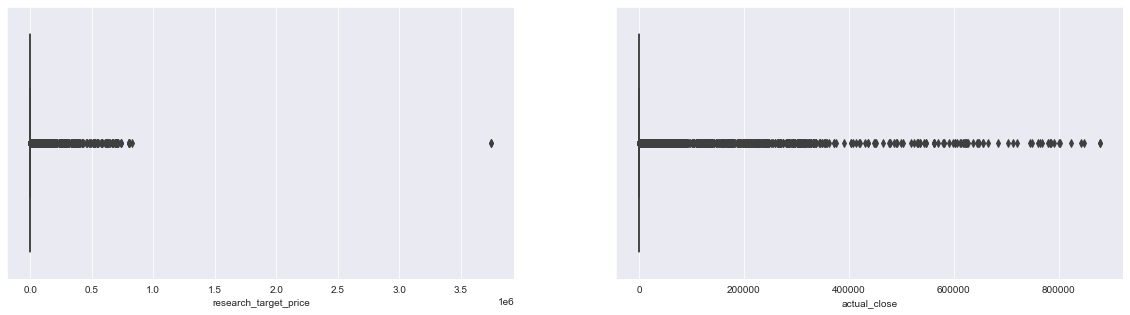

In [31]:
# plot research_target_price and actual_close
fig, ax = plt.subplots(1,2, figsize = (20,5))
sns.boxplot(x = final_frame.research_target_price, ax = ax[0])
sns.boxplot(x = final_frame.actual_close, ax = ax[1]);

Identifying the outlier(s) in research_target_price:

In [32]:
final_frame.loc[final_frame.research_target_price > 1000000] #looks for those outliers in the above "research_target_price" plot.

date                    research_report_id research_provider_id  \
1802  24/02/2013  4a7c2cb1-2de7-48af-9872-106862ec1b06               Bank 1   
3690  05/08/2013  25af41ef-9f78-44dc-8264-f6b5a1e865ac               Bank 1   

     lead_author_id symbol research_rating research_publish_date  \
1802      Author 37   TRNX            HOLD            24/02/2012   
3690      Author 37   TRNX            HOLD            08/05/2012   

     research_target_date  research_target_price  actual_close  ...  \
1802           24/02/2013              3750000.0   19559.90234  ...   
3690           08/05/2013              3750000.0   23999.88086  ...   

     esgPerformance coal pesticides adult percentile peerGroup smallArms  \
1802            NaN  NaN        NaN   NaN        NaN       NaN       NaN   
3690            NaN  NaN        NaN   NaN        NaN       NaN       NaN   

      environmentScore governancePercentile militaryContract  
1802               NaN                  NaN              NaN  
3690               NaN                  NaN              NaN  

[2 rows x 46 columns]

The two values above appeared to be wrong and were dropped. <br>
Note: the research_target_prices were values provided by Upside Technologies, presumably extracted from some documents. It will be seen that many more of those values were actually wrong. 

In [33]:
pd.options.mode.chained_assignment = None
final_frame.drop(final_frame.loc[final_frame.research_target_price > 1000000].index, inplace = True) # drops those outliers

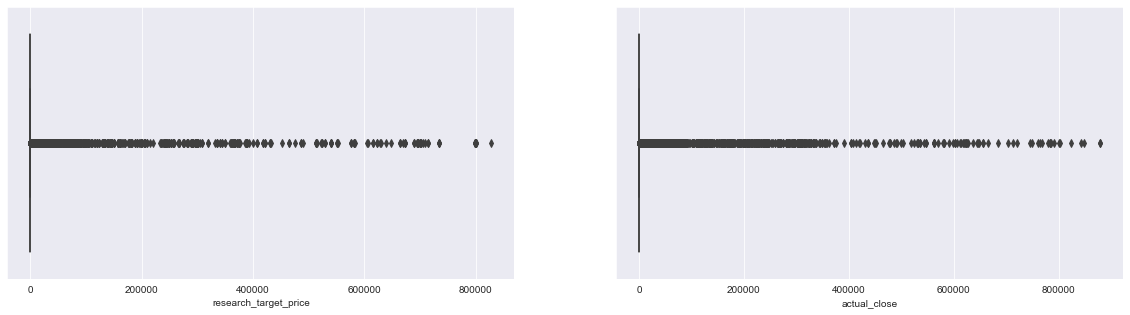

In [34]:
# plot research_target_price and actual_close (after the outliers cleaning)
fig, ax = plt.subplots(1,2, figsize = (20,5))
sns.boxplot(x = final_frame.research_target_price, ax = ax[0])
sns.boxplot(x = final_frame.actual_close, ax = ax[1]);

### 5.4.1 Dealing with 0 and next to 0 values in the stock prices predictions
This was the main work on the outliers. Firstly, all those zero or next to zero values were investigated:

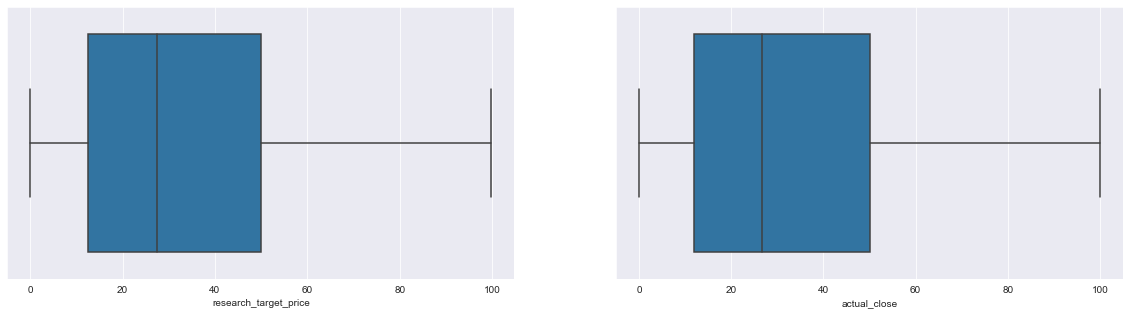

In [35]:
# plots with focus on all the research_target_price and actual_close < 100 
fig, ax = plt.subplots(1,2, figsize = (20,5))
sns.boxplot(x = final_frame.loc[final_frame.research_target_price < 100].research_target_price, ax = ax[0])
sns.boxplot(x = final_frame.loc[final_frame.actual_close < 100].actual_close, ax = ax[1]);

The above plots showed that there were not many zeros but many small values. <br> The scatter plot on different zoom levels of these two variables, against each other, clarified things. Plots below:

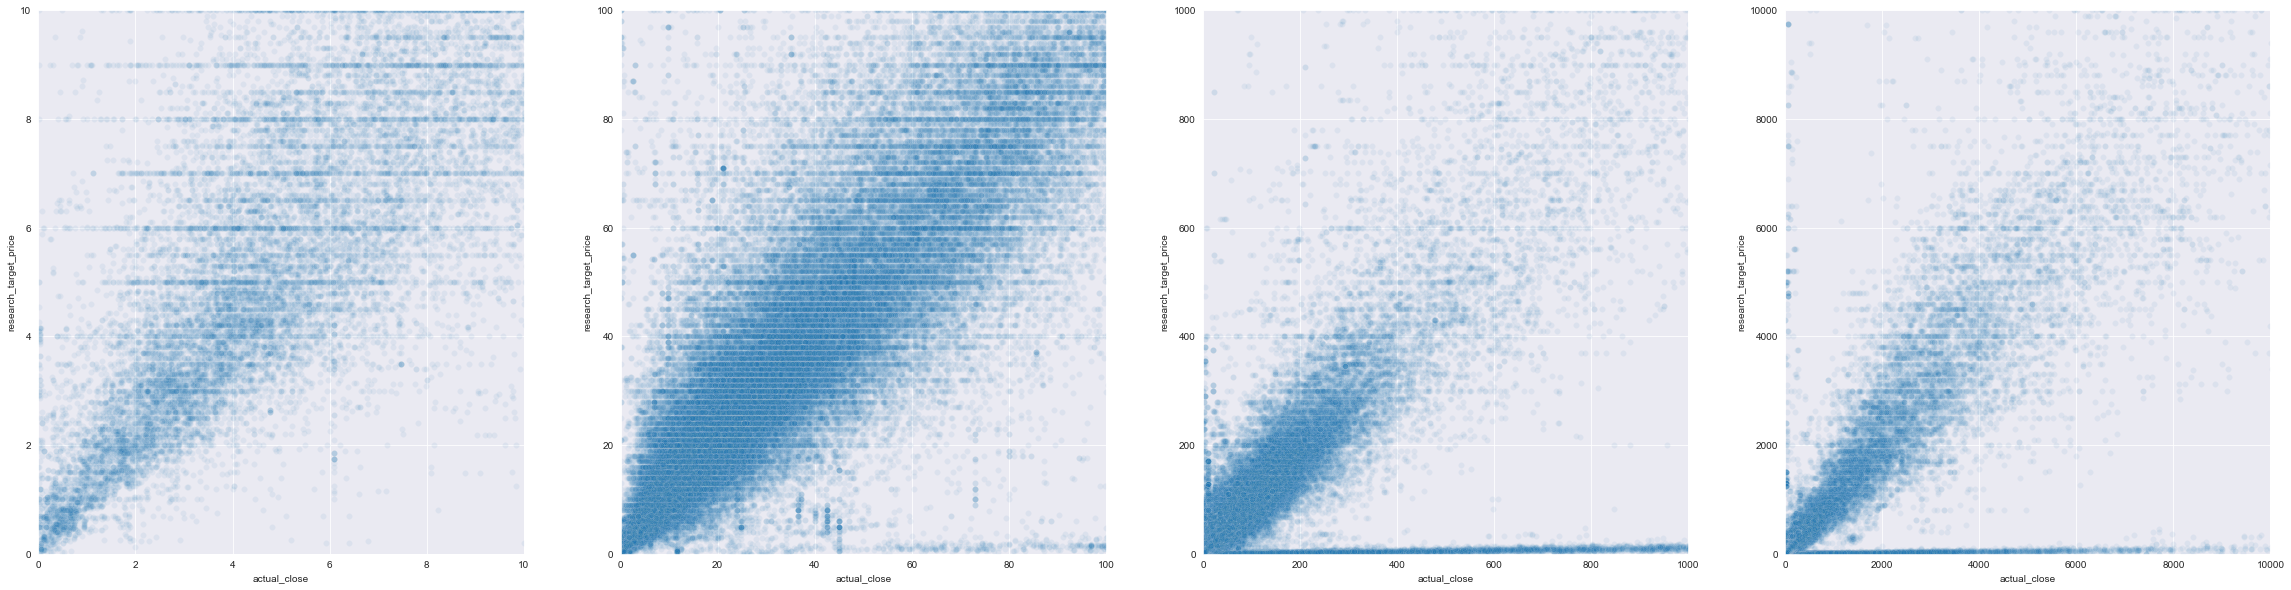

In [36]:
# plots pf actual close vs research_targtet_close at different scales 
fix, ax = plt.subplots(1,4, figsize = (40,10))
lim = [10, 100, 1000, 10000]
for i in range(len(lim)):
    sns.scatterplot(x = final_frame.actual_close, y = final_frame.research_target_price, alpha = 0.07, ax = ax[i]);
    ax[i].set_xlim(0, lim[i])
    ax[i].set_ylim(0, lim[i])

The above plots, zooming in at different scales, showed that there were many outliers along the x axis (subplot 2, 3, 4). <br> With a high level of transparency it was also possible to see (subplot 1, 2) these as parallel horizontal lines. <br>
The data was cleaned by removing the research_target_price values over 3 standard deviations away from the actual close median value. 

In [25]:
actual_close_median = final_frame.groupby('symbol')['actual_close'].median() # finds the median of the research_target_prices
actual_close_std = final_frame.groupby('symbol')['actual_close'].std() # # finds the standard deviation of the research_target_prices

In [23]:
# set the outliers research target prices to NaN and then drop them (keeps the dataframe without them)
for s in actual_close_std.index:
    final_frame.loc[(final_frame.symbol == s) & (final_frame.research_target_price < (actual_close_median[s] - 3 * actual_close_std[s])), "research_target_price"] = np.NAN # sets the research_target_price > median + 3 * std = np.Nan
for s in frame_std.index:
    final_frame.loc[(final_frame.symbol == s) & (final_frame.research_target_price > (actual_close_median[s] + 3 * actual_close_std[s])), "research_target_price"] = np.NAN # sets the research_target_price < median + 3 * std = np.Nan
final_frame = final_frame[final_frame['research_target_price'].notna()]

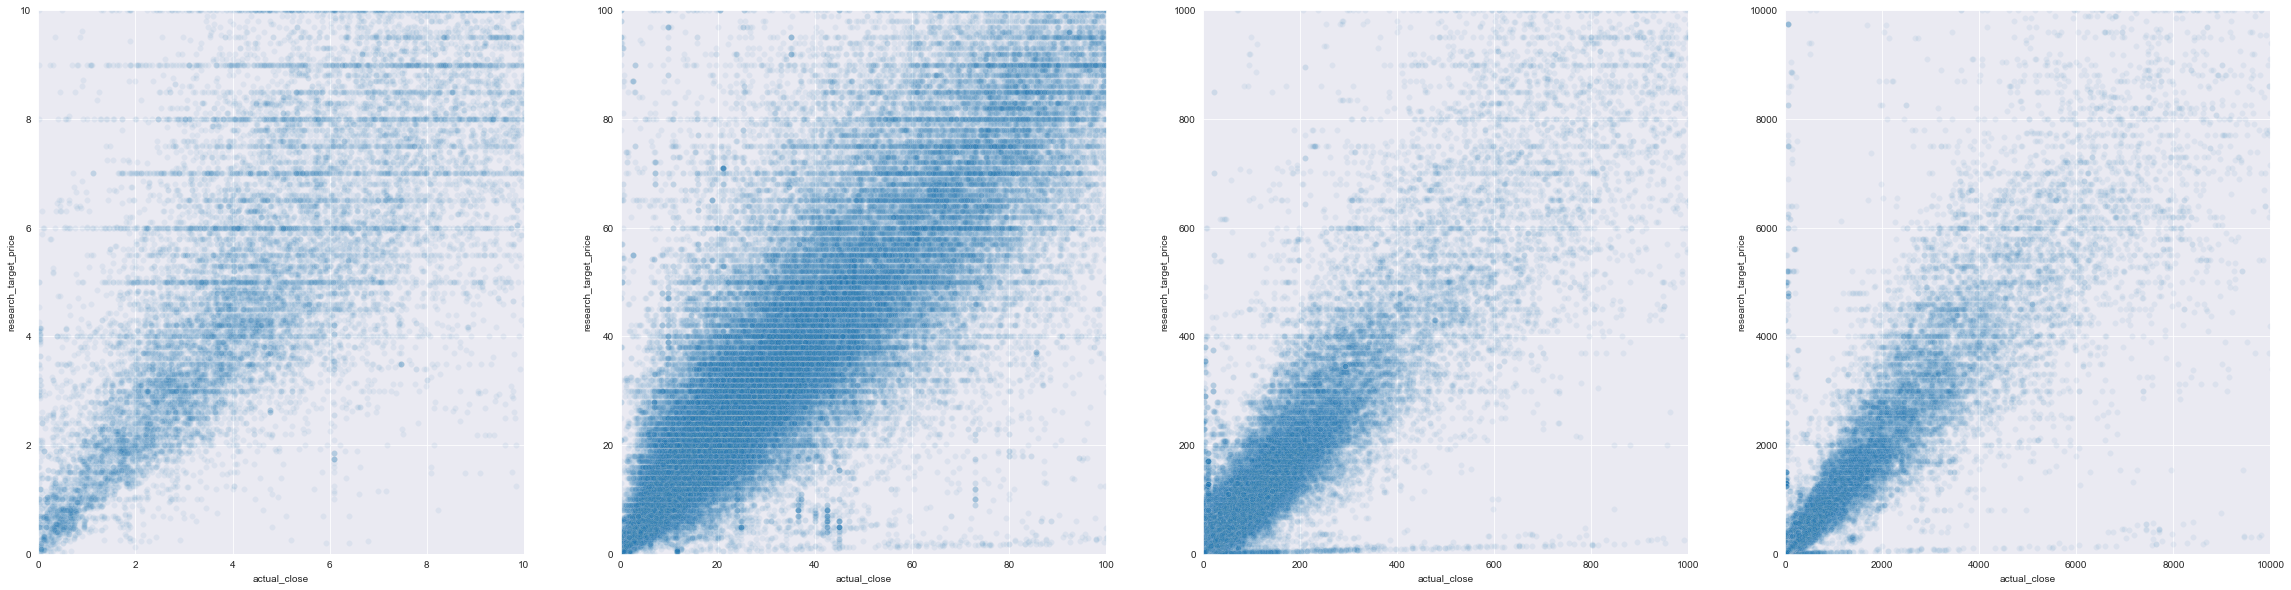

In [39]:
# scatter plots after cleaning
fix, ax = plt.subplots(1,4, figsize = (40,10))
lim = [10, 100, 1000, 10000]
for i in range(len(lim)):
    sns.scatterplot(x = final_frame.actual_close, y = final_frame.research_target_price, alpha = 0.07, ax = ax[i]);
    ax[i].set_xlim(0, lim[i])
    ax[i].set_ylim(0, lim[i])

Noticeable improvements could be seen in subplots 3 and 4, whilst subplots 1 and 2 still showed the horizonal lines. Given the cleaning, these would seem to indicate fixed predictions on stocks that had a high variance. 


In [483]:
final_frame.shape

(122430, 46)

## 5.4.2 Market capitalization
Moving on to the market capitalization values, some outliers were spotted.

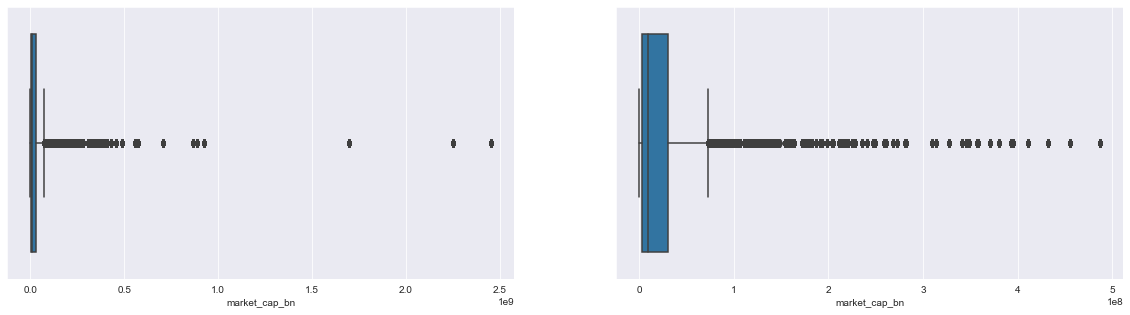

In [40]:
fig, ax = plt.subplots(1,2, figsize = (20,5))
sns.boxplot(x = final_frame.market_cap_bn, ax = ax[0]); # plots all the companies
sns.boxplot(x = final_frame.loc[final_frame.market_cap_bn < 500000000].market_cap_bn, ax = ax[1]); # plots all the companies without the major outliers

The top three were Apple, Microsoft and Amazon (which made sense).

In [41]:
# finds the main group of outliers 
final_frame.loc[final_frame.market_cap_bn > 1000000000].groupby('symbol')['market_cap_bn'].max().sort_values(ascending = False)

symbol
AAPL    2.456383e+09
MSFT    2.252363e+09
AMZN    1.696388e+09
Name: market_cap_bn, dtype: float64

The second big group of outliers were: "Google", "Facebook", "Tesla", "Tencent Holdings" (Chinese tech conglomerate holding company), "Nvidia" and  "Taiwan Semiconductor Manufactruing". To note that GOOG and GOOGL were stock ticker symbols for Google Alphabet with the main difference being that GOOG shares had no voting rights while GOOGL shares did. If added them up GOOGL would have jumped right above Amazon, in the main group of outliers.

In [42]:
# finds the second group of outliers 
final_frame.loc[(final_frame.market_cap_bn > 500000000) & (final_frame.market_cap_bn < 1000000000)].groupby('symbol')['market_cap_bn'].max().sort_values(ascending = False) # second group of outliers

symbol
GOOG       925610335.2
FB         888279977.3
GOOGL      867147821.2
TSLA       704811578.5
0700.HK    574941800.5
NVDA       564089120.0
2330.TW    556334310.7
Name: market_cap_bn, dtype: float64

In [43]:
print("Market capitalization mean = {}" .format(final_frame.market_cap_bn.mean()))
print("Market capitalization median = {}" .format(final_frame.market_cap_bn.median()))

Market capitalization mean = 41749662.85511548
Market capitalization median = 9597475.914


Checking for next to zero values. There was none and that column looked clean and made sense. 

In [44]:
final_frame.market_cap_bn.min() #checks for the smallest value

2601.296618

All the outliers in this case were considered informative and left in the dataframe. 

## 5.4.3.  Country

In [41]:
analysis_countries = final_frame.country.value_counts() # counts how many research reports  per country
analysis_countries; # hidden output - plotted below 

In [42]:
companies_contry = final_frame.groupby('country')['symbol'].nunique().sort_values(ascending = False) #counts how many companies per country
companies_contry; # hidden output - plotted below 

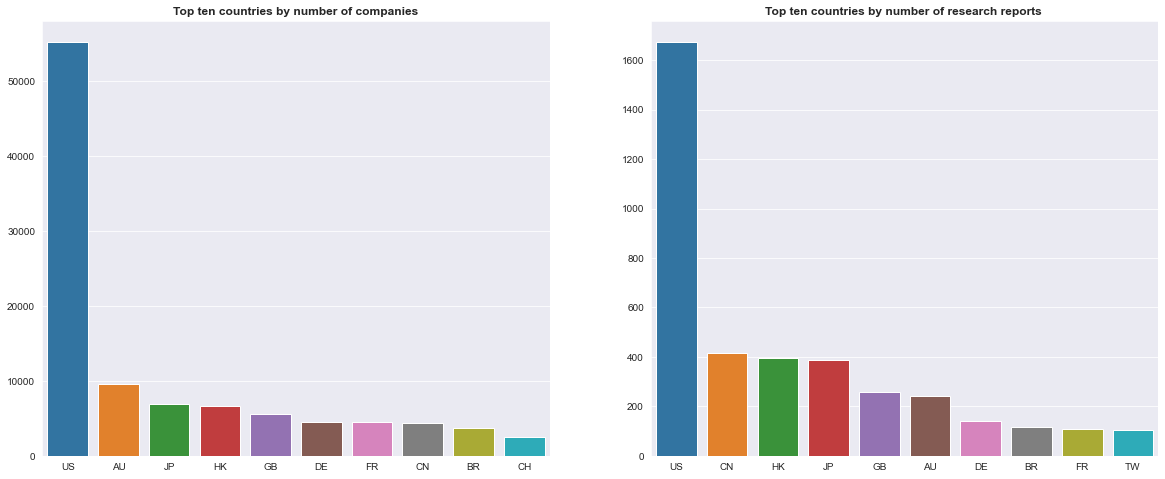

In [43]:
# plot the above variables
fig, ax = plt.subplots(1,2, figsize = (20,8))
sns.barplot(x = analysis_countries.index[0:10], y = analysis_countries.values[0:10], ax = ax[0] );
sns.barplot(x = companies_contry.index[0:10], y = companies_contry.values[0:10], ax = ax[1] );
ax[0].set_title('Top ten countries by number of companies', fontweight = 'bold');
ax[1].set_title('Top ten countries by number of research reports ', fontweight = 'bold');
ax[1].set_xlabel("");

The above plots show how the number of published reports varied by country, and so did the number of companies. The two are not always correlated and there are countries like China and Honk Kong that proportionally receive a larger number of analysis per company. What's particulalry evident is the prevalence of US companies and reports on them. US could be defined as an outlier with this regards. 

## 5.4.4. Sector and Industry

In [48]:
print("Number of unique sectors = {}" .format(final_frame.sector.nunique()))
print("Number of unique industries = {}" .format(final_frame.industry.nunique()))

Number of unique sectors = 20
Number of unique industries = 129


In [49]:
analysis_sector = final_frame.sector.value_counts() # prepares the sectors to be plotted
analysis_industry = final_frame.industry.value_counts() # prepares the countries to be plotted

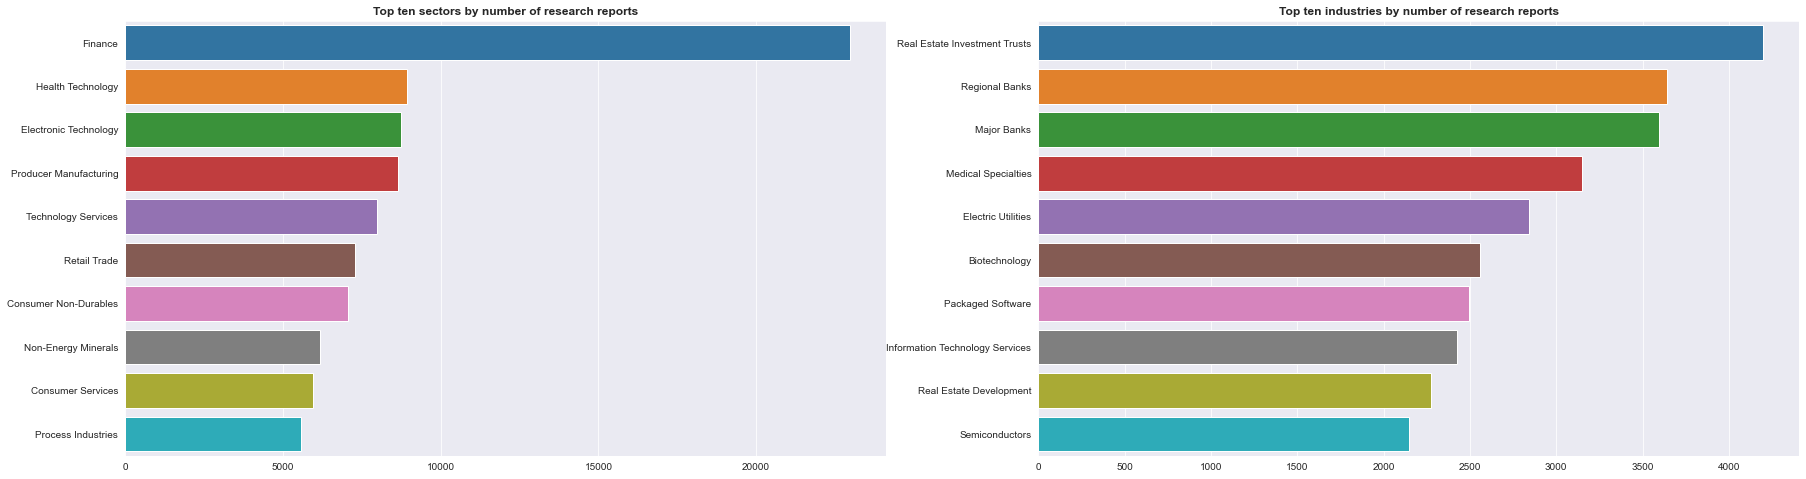

In [60]:
# plot the above variables
fig, ax = plt.subplots(1,2, figsize = (30,8))
sns.barplot(x = analysis_sector.values[0:10], y = analysis_sector.index[0:10], ax = ax[0] );
sns.barplot(x = analysis_industry.values[0:10], y = analysis_industry.index[0:10], ax = ax[1] );
ax[0].set_title('Top ten sectors by number of research reports', fontweight = 'bold');
ax[1].set_title('Top ten industries by number of research reports', fontweight = 'bold');
ax[1].set_xlabel("");

The above plots show a high prevalence in research reports published on the Financial sector. The research reports on the different industries are much more balanced (and detailed). Futher analysis would benefit from studying the industries rather than the sectors. 

In [47]:
print("Number of companies without a sector = {}".format(final_frame.loc[final_frame.sector.isna()].symbol.nunique()))

Number of companies without a sector = 0


## 5.4.5. Market capitalization size

In [99]:
cap_size = final_frame.market_cap_classification.value_counts() # prepares the market capitalization size to be plotted

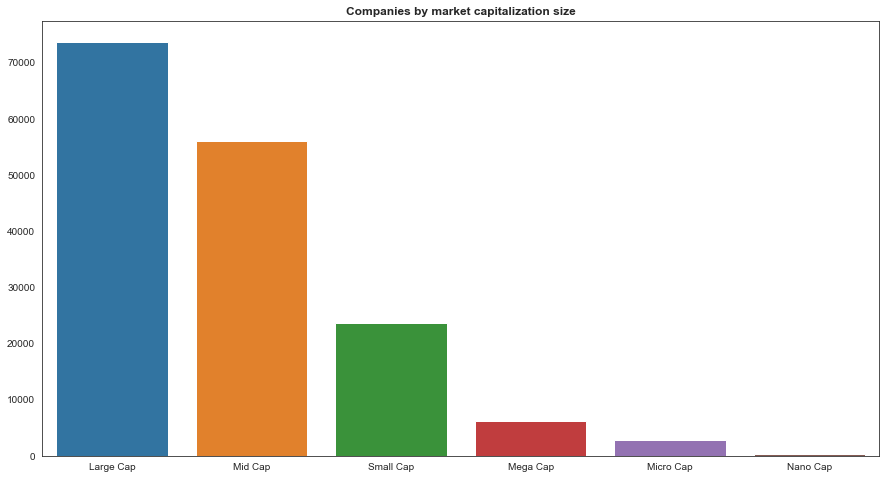

In [101]:
fig, ax = plt.subplots(figsize = (15,8))
sns.barplot(x = cap_size.index, y = cap_size.values);
ax.set_title('Companies by market capitalization size', fontweight = 'bold');

## 5.4.6. ESG values 

ESG scores have recently become something that most analysts consider when recommending to buy a company. Unfortunately, this is a relatively new metric and it was only possible to find values for just over half of all the companies in this study. <br> In this project the analysis was limited to the four most important ESG values: environment score, social score, governance score and total score. <br>
Note: higher scores identify a higher unmanaged ESG risk. Lower scores suggest lower ESG risk and are therefore preferable. 

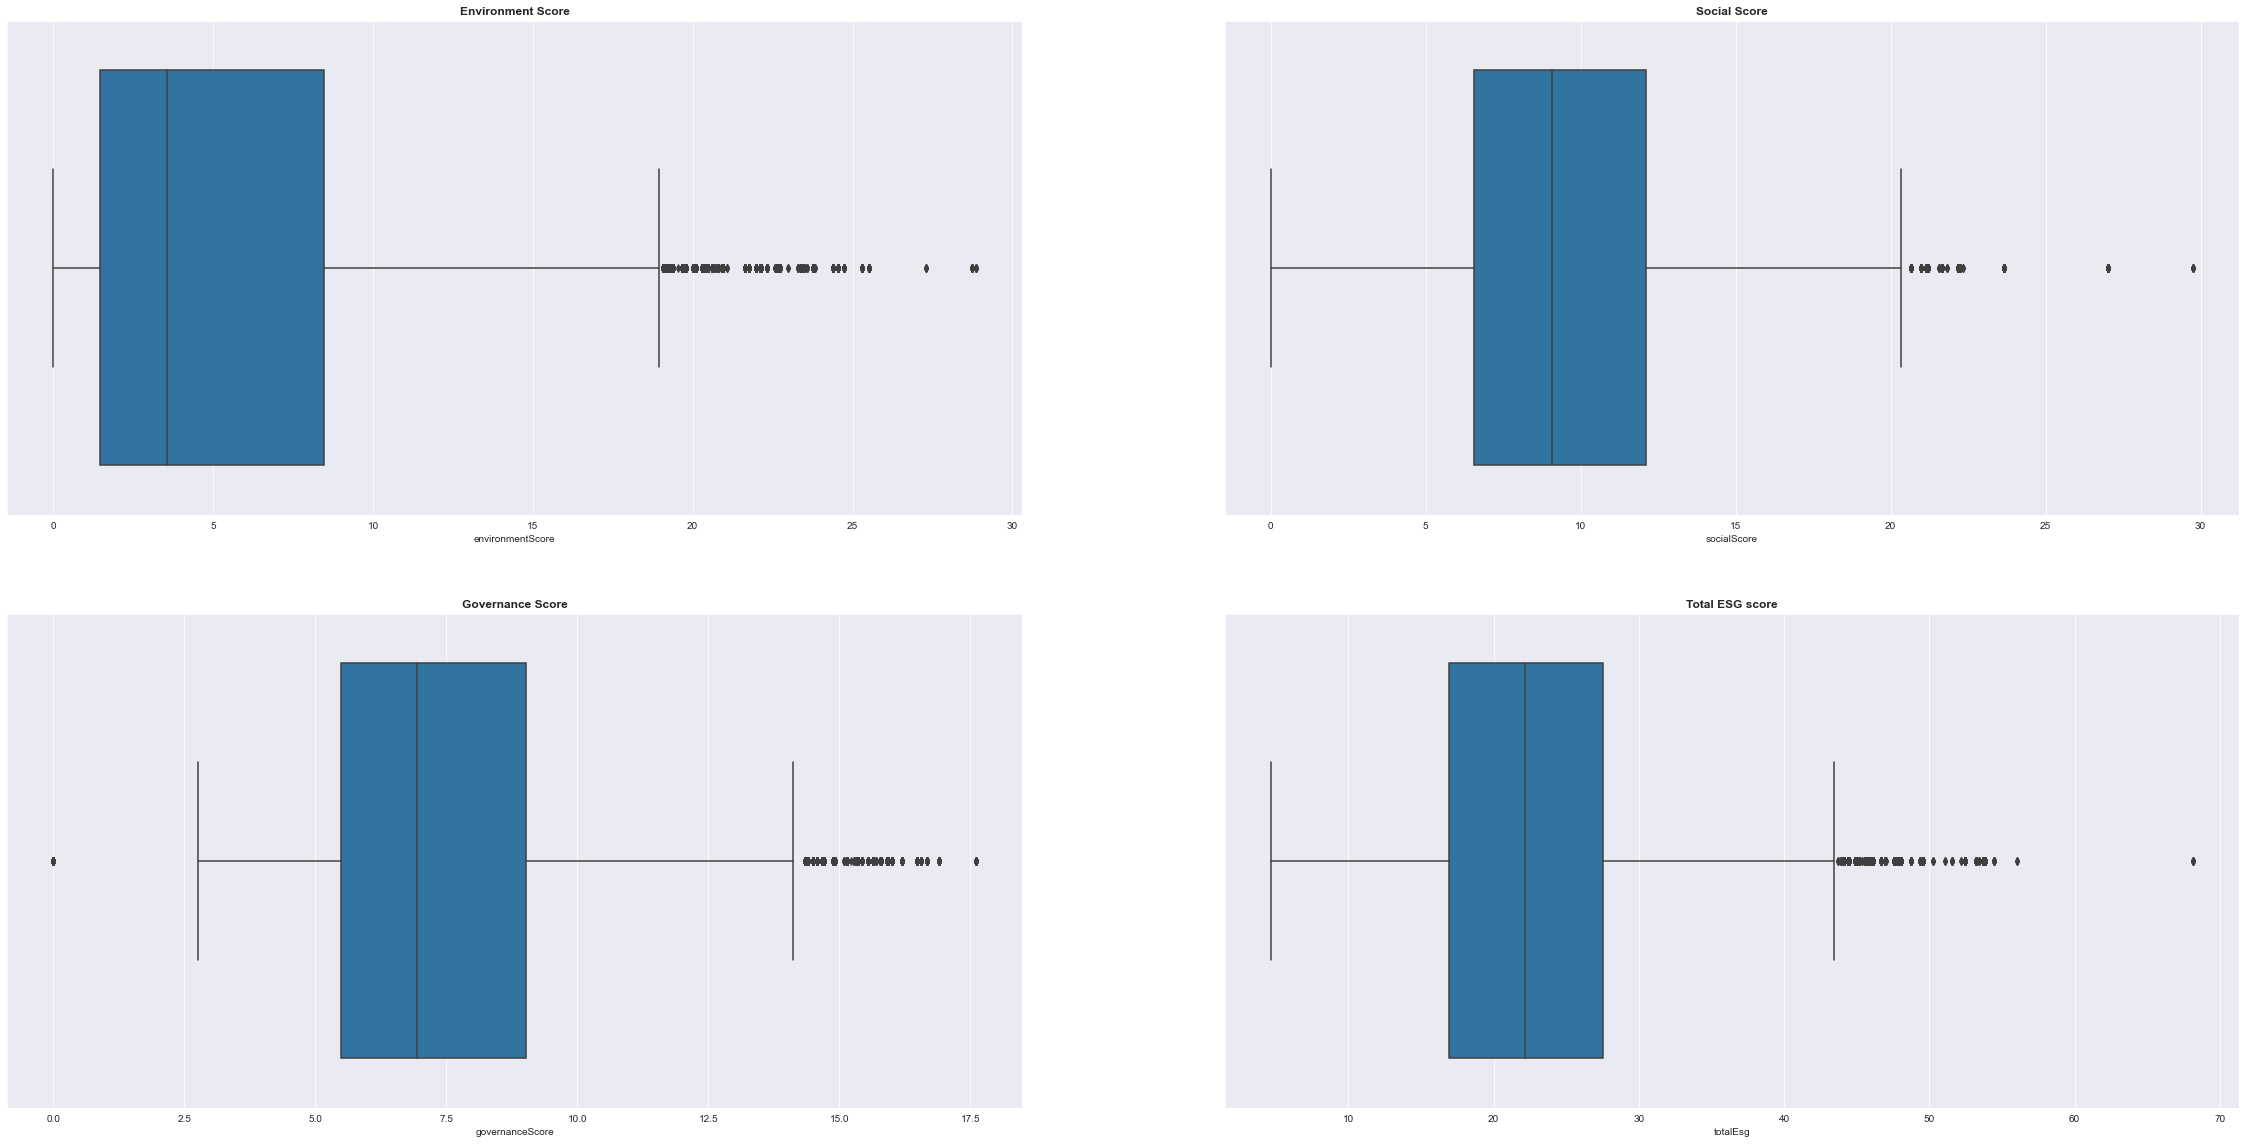

In [63]:
# plots of the four most important ESG features
fig, ax = plt.subplots(2, 2, figsize = (40, 20))
sns.boxplot(x = final_frame.environmentScore, ax = ax[0][0])
sns.boxplot(x = final_frame.socialScore, ax = ax[0][1])
sns.boxplot(x = final_frame.governanceScore, ax = ax[1][0])
sns.boxplot(x = final_frame.totalEsg, ax = ax[1][1]);
ax[0][0].set_title("Environment Score", fontweight = 'bold');
ax[0][1].set_title("Social Score", fontweight = 'bold');
ax[1][0].set_title("Governance Score", fontweight = 'bold');
ax[1][1].set_title("Total ESG score", fontweight = 'bold');

In [79]:
print("Number of companies that have a particularly bad ESG score = {}".format(final_frame.loc[final_frame.totalEsg > 42].symbol.nunique()))

Number of companies that have a particluarly bad ESG score = 51


In [89]:
print("The worst performer company is {} : Tokyo Electric Power Company Holdings".format(final_frame.loc[final_frame.totalEsg > 60].symbol.unique()[0]))

The worst performer company is 9501.T : Tokyo Electric Power Company Holdings


The above plots show several outliers in terms of ESG values and in most cases these are companies with very high (bad) scores. <br> Below some futher study on this. 

### Industries with the highest unmanaged ESG risk

In [91]:
final_frame.loc[final_frame.totalEsg > 42].industry.unique() # outliers industries in terms of (bad) ESG scores 

array(['Oil & Gas Production', 'Construction Materials',
       'Chemicals: Agricultural', 'Industrial Machinery',
       'Industrial Specialties', 'Other Metals/Minerals', 'Coal', 'Steel',
       'Aluminum', 'Integrated Oil', 'Alternative Power Generation',
       'Engineering & Construction', 'Electric Utilities',
       'Finance/Rental/Leasing', 'Oil & Gas Pipelines',
       'Oil Refining/Marketing', 'Food: Meat/Fish/Dairy',
       'Wholesale Distributors', 'Chemicals: Specialty',
       'Containers/Packaging', 'Food: Specialty/Candy', 'Regional Banks',
       'Precious Metals', 'Home Furnishings'], dtype=object)

In [112]:
worst_esg = final_frame.groupby('industry')['totalEsg'].mean().sort_values(ascending = False) # prepares worst_esg to plot
best_esg = final_frame.groupby('industry')['totalEsg'].mean().sort_values(ascending = True) # prepares best_esg to plot

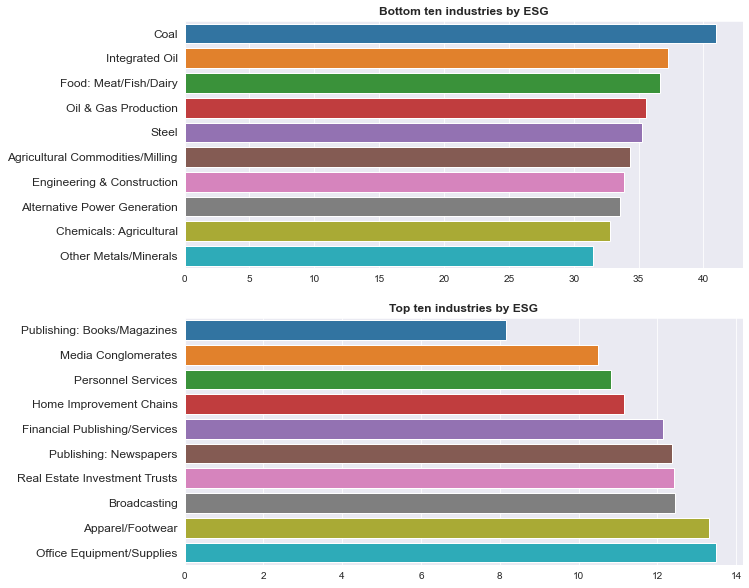

In [156]:
# plot ten worst and best industries by ESG (higher scores indicate a higher risk = bad scores)
fig, ax = plt.subplots(2,1, figsize = (10,10))
sns.barplot(x = worst_esg.values[0:10], y = worst_esg.index[0:10], ax = ax[0] );
sns.barplot(x = best_esg.values[0:10], y = best_esg.index[0:10], ax = ax[1] );
ax[0].set_title('Bottom ten industries by ESG', fontweight = 'bold', fontsize = 12);
ax[1].set_title('Top ten industries by ESG', fontweight = 'bold', fontsize = 12);
ax[0].set_ylabel("");
ax[1].set_ylabel("");
ax[0].set_yticklabels(worst_esg.index[0:10], fontsize=12);
ax[1].set_yticklabels(best_esg.index[0:10], fontsize=12);

The above plots show the 10 worst and best idustries in terms of ESG vales (quite interesting!)

In [105]:
print("The lowest (best) ESG risk score goes to {} : Unibail-Rodamco-Westfield, operating  in {}.".format(final_frame.loc[final_frame.totalEsg == final_frame.totalEsg.min()].symbol.unique()[0], final_frame.loc[final_frame.symbol == 'URW.AS'].industry.unique()[0]))

The lowest (best) ESG risk score goes to URW.AS : Unibail-Rodamco-Westfield, operating  in Real Estate Development.


###### Time series analysis

Below a very insightful plot that showed how, in the data provided, the years between 2013 and late 2016 saw exclusively researches reports published by Bank 1. From 2017 things changed with a prevalence of researches reports published by Bank 2, which seemed to target a more significant number of large market capitalization companies. 

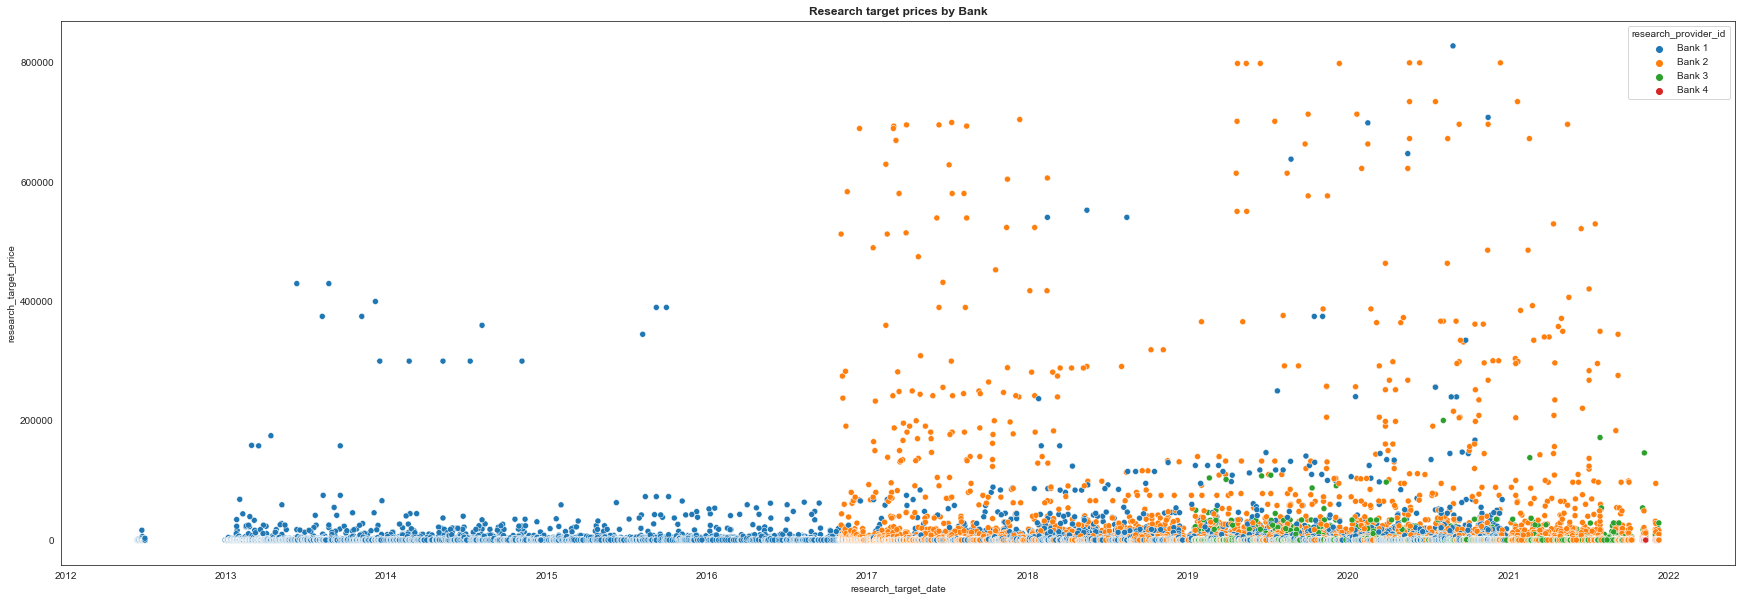

In [396]:
# plot the 10 analysts (for number of published right researches) prices and hue for author and size for provider
fig, ax = plt.subplots( figsize = (30,10));
sns.scatterplot(x = final_frame.index, y = final_frame.research_target_price, hue = frame.research_provider_id, alpha = 1);
plt.title("Research target prices by Bank", fontweight = 'bold');

###### Clustering 

Clustering and MCA were used to investigate on the question: <i> "Do features such as sector, country or company size influence the ratings received?" </i>

In [442]:
clust_cat = final_frame[['country', 'industry', 'market_cap_classification' ]] # selecting the columns to cluster
clust_cat = clust_cat.dropna() # dropping  null values

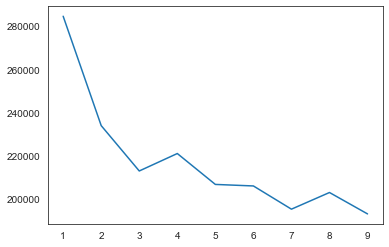

In [443]:
# calculating the optimal number of clusters
cost = []
for num_clusters in list(range(1,10)):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 3, verbose=0)
    kmode.fit_predict(clust_cat.iloc[:, 0:3])
    cost.append(kmode.cost_)
x = np.array([i for i in range(1,10,1)])
sns.lineplot(x = x, y = cost);

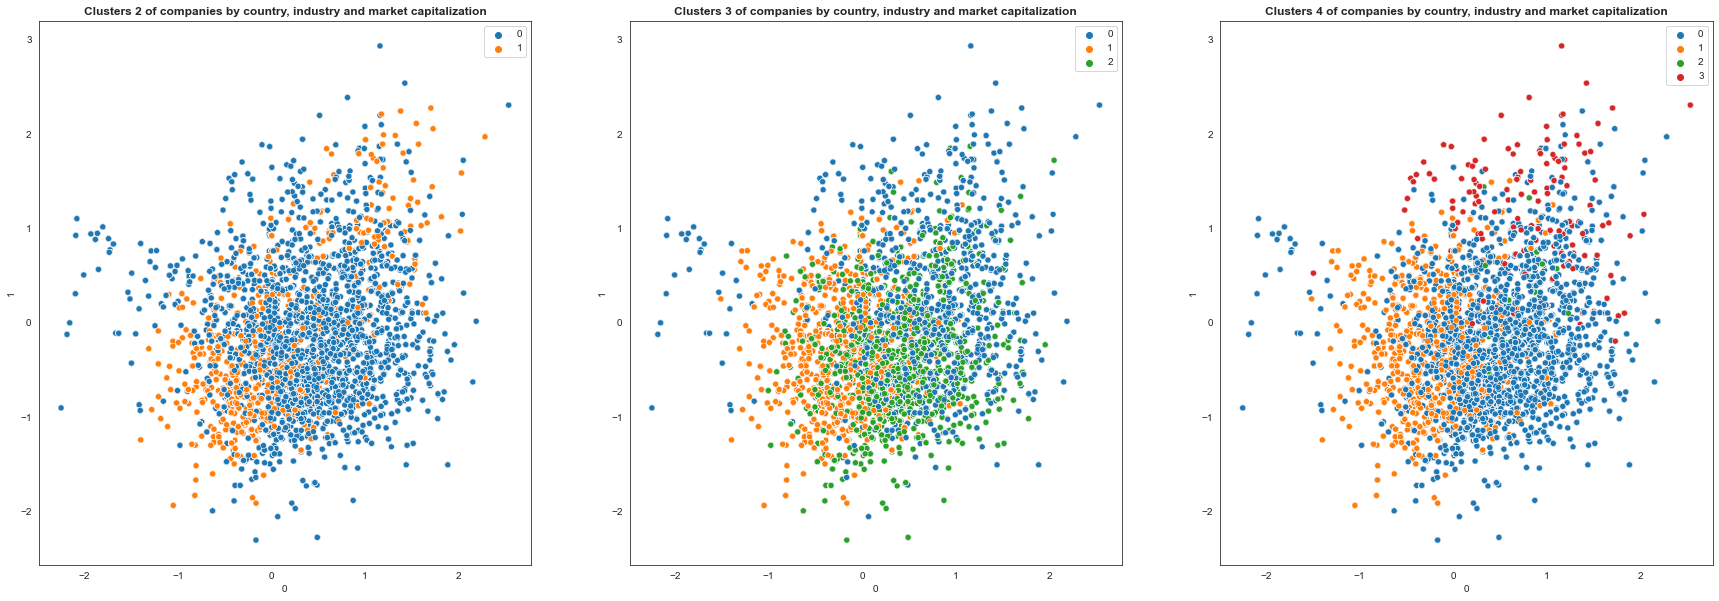

In [445]:
# plotting the data trying different numbers of clusters
fig, ax = plt.subplots(1, 3, figsize = (30, 10))
mca = prince.MCA( n_components=2, n_iter=10, copy=True,  check_input=True, engine='auto', random_state=42)
mca = mca.fit(clust_cat)
mca_cor = mca.row_coordinates(clust_cat)
for i in np.arange(2,5):
    km = KModes(n_clusters = i, init = 'Huang', n_init = 1, verbose = 0) # creating the model
    fitClusters_huang = km.fit_predict(clust_cat.iloc[:, 0:3])  # fitting the model
    sns.scatterplot(ax = ax[i - 2], x = mca_cor.iloc[:,0], y = mca_cor.iloc[:,1], hue = fitClusters_huang, palette = 'tab10')
    ax[i - 2].set_title("Clusters " + str(i) + " of companies by country, industry and market capitalization", fontweight = 'bold');

Clustering and Multiple Correspondence Analysis (MCA) were used to try finding clusters of companies in the data but the results did not show any clear clusters. Futher work on this later.

# 6. Scraping other close values

It was realized that together with the close value at the "research_target_date" (column called: <i> "close_target_date" </i>) it was important to have the companies close values at the time of the "research_publish_date" as well (called: <i> "close_publish_date" </i>). This would help understand the stock trends over the year and where the stocks were when the analysts made their prediction. <br> Yahoo Finance was scraped again... (5200 loops and about 2 hours to complete.)

## 6.1 Close values scraper


In [ ]:
list_of_frames = []
counter = 0
for ticker in final_frame.symbol.unique():  
    counter += 1
    print('loop number {}'.format(counter))   
    to_merge = final_frame.loc[final_frame.symbol == ticker]   # the following 5 lines extract a company from the main dataframe and save it to a new frame.
    to_merge['Date'] = pd.to_datetime(to_merge['research_publish_date'], dayfirst=True)
    to_merge.set_index('Date', inplace=True)
    to_merge = to_merge.sort_index(ascending=True)
    to_merge['Close'] = np.NaN
    try:
        yfticker = yf.download(ticker, start = '2011-01-01', end = '2021-10-01', interval = '1d', Threads = False, groupby = 'ticker')  # this is the scraper. Original source: https://github.com/ranaroussi/yfinance     
        dframe = pd.DataFrame(yfticker.Close.reset_index()) # the following 3 lines create a dataframe with the close values for the ticker company.
        dframe['symbol'] = ticker
        dframe.set_index('Date', inplace=True)
        merged = pd.merge_asof(to_merge, dframe, by = 'symbol', left_index = True, right_index=True, direction = 'nearest' )  # the previous frames are merged here.
        list_of_frames.append(merged)
    except KeyError:
        print('error')  # exceptions are mostly due to companies not found. 
    except TypeError: 
        print('error')  
    except ValueError: 
        print('error')

loop number 5201
[*********************100%***********************]  1 of 1 completed
loop number 5202
[*********************100%***********************]  1 of 1 completed
loop number 5203
[*********************100%***********************]  1 of 1 completed
loop number 5204
[*********************100%***********************]  1 of 1 completed
loop number 5205
[*********************100%***********************]  1 of 1 completed
loop number 5206
[*********************100%***********************]  1 of 1 completed

In [ ]:
frame = pd.concat(list_of_frames) # concatenates the frames 

In [ ]:
frame.rename(columns={"Close": "close_publish_date", 
                      "actual_close": "close_target_date"}) # rename the close columns

In [5]:
#frame.to_csv('frame.csv') -- commented out to avoid repeated savings

# 7. Feature derivation 

One of the main goals of this study was to understand how often the analysts were right in their predictions and if there were patterns that could explain their accuracy. Classifying the predictions was the first main resut of all the previous preparatory work and a milestone in this project.    

## 7.1 Predictions results

In [15]:
frame = pd.read_csv('frame.csv')

In [4]:
frame.head(2)

research_report_id research_provider_id lead_author_id  \
0  38c1927d-8c92-484f-8664-17f8d4a8da50               Bank 1       Author 0   
1  9570fa0c-15df-41ab-81ea-5942701ffc67               Bank 1     Author 278   

  symbol research_rating research_publish_date research_target_date  \
0     GM             BUY            12/06/2011           12/06/2012   
1     GM             BUY            01/11/2012           01/11/2013   

   research_target_price  close_publish_date  close_target_date  ...  \
0                   46.0               28.59          22.170000  ...   
1                   30.0               25.68          37.389999  ...   

  esgPerformance   coal pesticides  adult percentile    peerGroup smallArms  \
0      LEAD_PERF  False      False  False      61.37  Automobiles     False   
1      LEAD_PERF  False      False  False      61.37  Automobiles     False   

   environmentScore governancePercentile militaryContract  
0             10.28                  0.0            False  
1             10.28                  0.0            False  

[2 rows x 46 columns]

The code below labels the analysts' predictions:

In [5]:
frame['prediction_result'] = np.nan # creates the column to fill
#setting all the "right" indexes
idx_right_buy = (frame.research_rating == 'BUY') & (frame.close_publish_date < frame.close_target_date)
idx_right_sell = (frame.research_rating == 'SELL') & (frame.close_publish_date > frame.close_target_date)
idx_right_strong_buy = (frame.research_rating == 'STRONG_BUY') & (frame.close_publish_date < frame.close_target_date)
idx_right_hold = (frame.research_rating == 'HOLD') & (frame.close_publish_date <= frame.close_target_date)
#setting all the "wrong" indexes
idx_wrong_buy = (frame.research_rating == 'BUY') & (frame.close_publish_date > frame.close_target_date)
idx_wrong_strong_buy = (frame.research_rating == 'STRONG_BUY') & (frame.close_publish_date > frame.close_target_date)
idx_wrong_sell = (frame.research_rating == 'SELL') & (frame.close_publish_date <= frame.close_target_date)
idx_wrong_hold = (frame.research_rating == 'HOLD') & (frame.close_publish_date > frame.close_target_date)
#setting all the "right" prediction labels
frame.loc[idx_right_buy, ['prediction_result']] = 1
frame.loc[idx_right_sell, ['prediction_result']] = 1
frame.loc[idx_right_hold, ['prediction_result']] = 1
frame.loc[idx_right_strong_buy, ['prediction_result']] = 1
#setting all the "right" prediction labels
frame.loc[idx_wrong_buy, ['prediction_result']] = 0
frame.loc[idx_wrong_sell, ['prediction_result']] = 0
frame.loc[idx_wrong_hold, ['prediction_result']] = 0
frame.loc[idx_wrong_strong_buy, ['prediction_result']] = 0

Labeling the predictions: 1 = 'right', 0 = "wrong".

# 8. Data analysis

 ## 8.1 <i> Question 1: Can analysts that perform significantly better than others be identified? </i>

###### Proportion of right predictions

In [6]:
print("Proportion of right predictions = {:2.2%} ".format(frame.prediction_result.sum() / len(frame.prediction_result)))

Proportion of right predictions = 56.68% 


###### Top analysts by number of correct predictions

In [7]:
top_analysts_abs = frame.groupby('lead_author_id')['prediction_result'].sum().sort_values(ascending = False)
top_analysts_abs

lead_author_id
Author 111     1028.0
Author 95      1015.0
Author 485      990.0
Author 38       957.0
Author 40       859.0
                ...  
Author 1185       0.0
Author 1372       0.0
Author 457        0.0
Author 1261       0.0
Author 1204       0.0
Name: prediction_result, Length: 1386, dtype: float64

###### Top analysts by percentage of correct predictions 

In [10]:
# takes the analysts with 50 or more right predictions
top_over_50 = top_analysts_abs.loc[top_analysts_abs.values >=50] 
# creates an index with their names
top_over_50_names = top_over_50.index 
# extract a dataframe from the main one with the best analysts
frame_top_50 = frame.loc[frame.lead_author_id.isin(top_over_50_names)] 
# calculates the ratio right predictions / total predictions
ratios_over_50 = frame_top_50.groupby('lead_author_id')['prediction_result'].sum()/ frame_top_50.groupby('lead_author_id')['prediction_result'].count() 
# select only the analysts with a success ratio over 75% (and at least 50 correct predictions made).
ratio_over_75pc_names = ratios_over_50.loc[ratios_over_50.values >= 0.75] 
# creates an index with their names
ratio_over_75pc_idx = ratio_over_75pc_names.index
# extract a dataframe from the main one with the analysts with a ratio over 75% (and at least 50 correct predictions made).
frame_over_75pc = frame.loc[frame.lead_author_id.isin(ratio_over_75pc_idx)]

In [11]:
print("Number of analysts with a success rate over 75% and at least 50 published reports = {}".format(frame_over_75pc.lead_author_id.nunique()))

Number of analysts with a success rate over 75% and at least 50 published reports = 53


In [12]:
# display names
ratio_over_75pc_names.sort_values(ascending = False); # remove the semicolon to see names 

<b> Important Note  </b> <br>   From this point on, in order to avoid the risk of studying obsolete data, such as analysts not longer working, or past market trends, this study focused on just the past 3 years, from 01.10.2018 to 01.10.2021.

In [2]:
# selecting only the last 3 years and the top analysts
recent_frame_over_75pc = frame_over_75pc['2018-10-01' : '2021-09-01']

In [3]:
 print("Number of active analysts with a success rate over 75% and at least 50 reports = {}".format(sum(recent_frame_over_75pc.lead_author_id.value_counts().values>50)))

###### Top analysts by percentage of correct prediction in the last 3 years

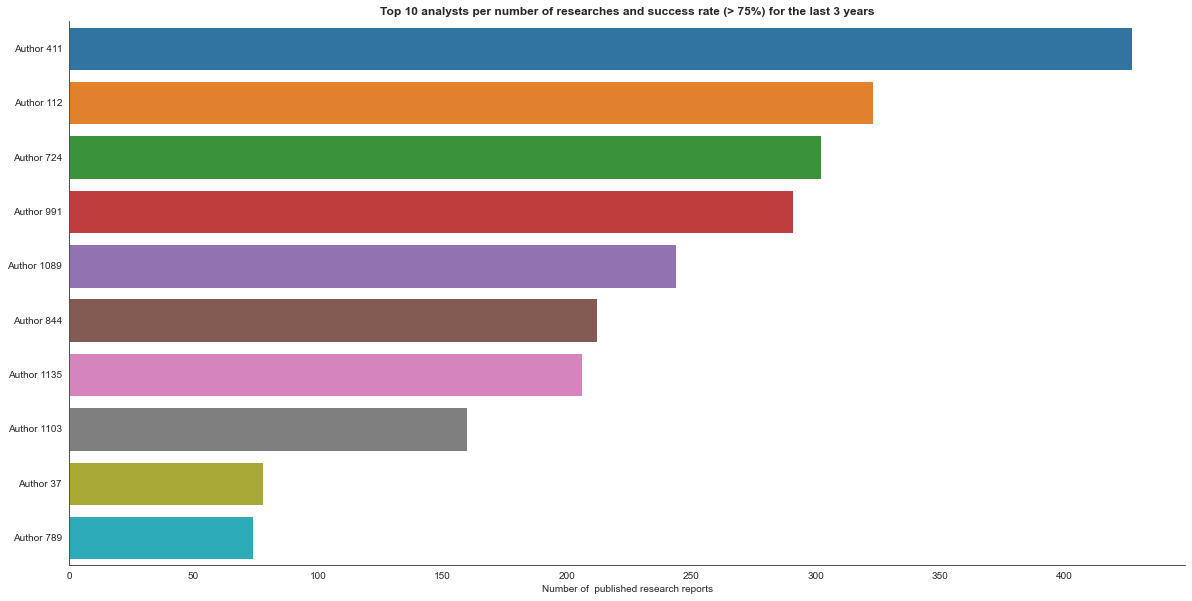

In [525]:
# select the top authors (analysts) in the last 3 years
authors = recent_frame_over_75pc.lead_author_id.value_counts()
# plot the number of researches per top analyst (success rate > 75%) for the last 3 years"
fig, ax = plt.subplots( figsize = (20,10))
sns.barplot(x = authors.values[0:10], y =  authors.index[0:10]);
plt.title("Top 10 analysts per number of researches and success rate (> 75%) for the last 3 years", fontweight = 'bold');
ax.set_xlabel('Number of  published research reports')
sns.despine()

## 8.1.1 Results

It was possible to identify the "correct prediction rate" for each analyst. The average success rate over the last 10 years was : 56.57%. <br> It was also possible to identify the analysts that in the last three years  had a success rate >= 75%  (with at least 50 reasearch reports published). 

## 8.2.  Question 2: Do features such as industry, country or company size influence the accuracy of  the ratings received?

###### Correlations 

In [1]:
# dython module taken from https://github.com/shakedzy/dython
# functions used in this module can be found here: https://github.com/shakedzy/dython/blob/master/dython/nominal.py
# shakedzy wrote a good article on correalation for categorical variables here: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

red_frame = recent_frame_over_75pc[["industry", "market_cap_classification", "country", "prediction_result"]]
associations(red_frame,  mark_columns = True, nom_nom_assoc = 'theil', cmap = "Blues", figsize = (15,10));

### 8.2.1 Industry 

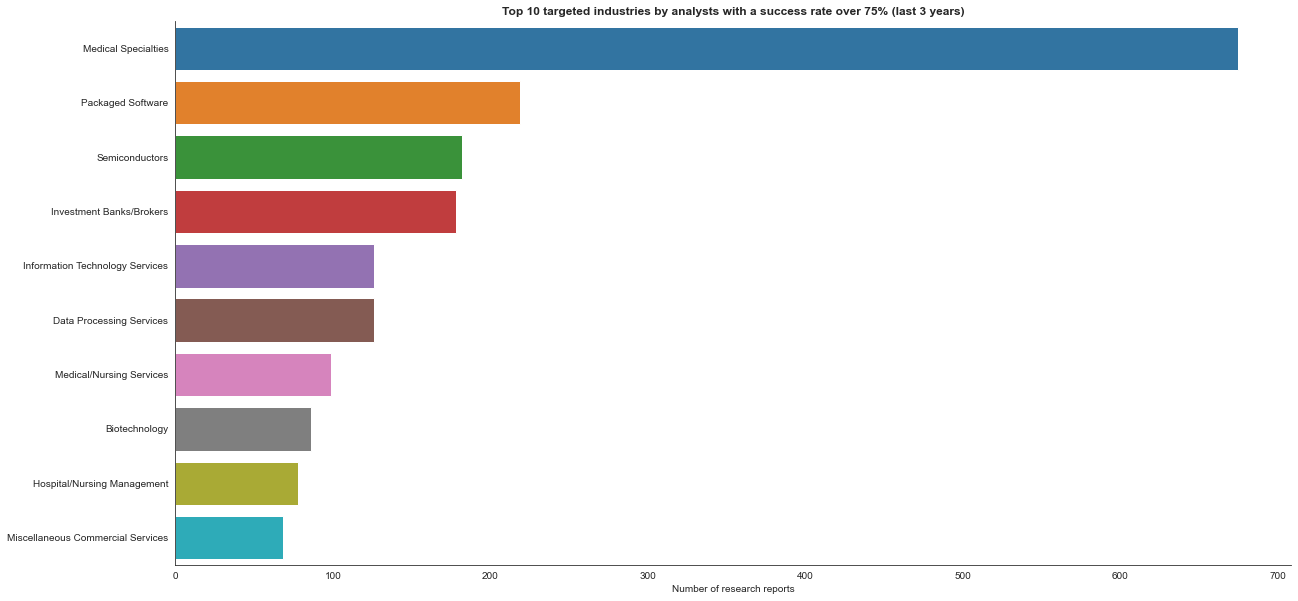

In [529]:
industry = recent_frame_over_75pc.industry.value_counts()[0:10] 
# plot targeted industries by analysts with a success rate over 75%
fig, ax = plt.subplots( figsize = (20,10))
sns.barplot(x = industry.values, y =  industry.index);
plt.title("Top 10 targeted industries by analysts with a success rate over 75% (last 3 years)", fontweight = 'bold');
ax.set_xlabel('Number of research reports')
sns.despine()

### 8.2.2. Sector

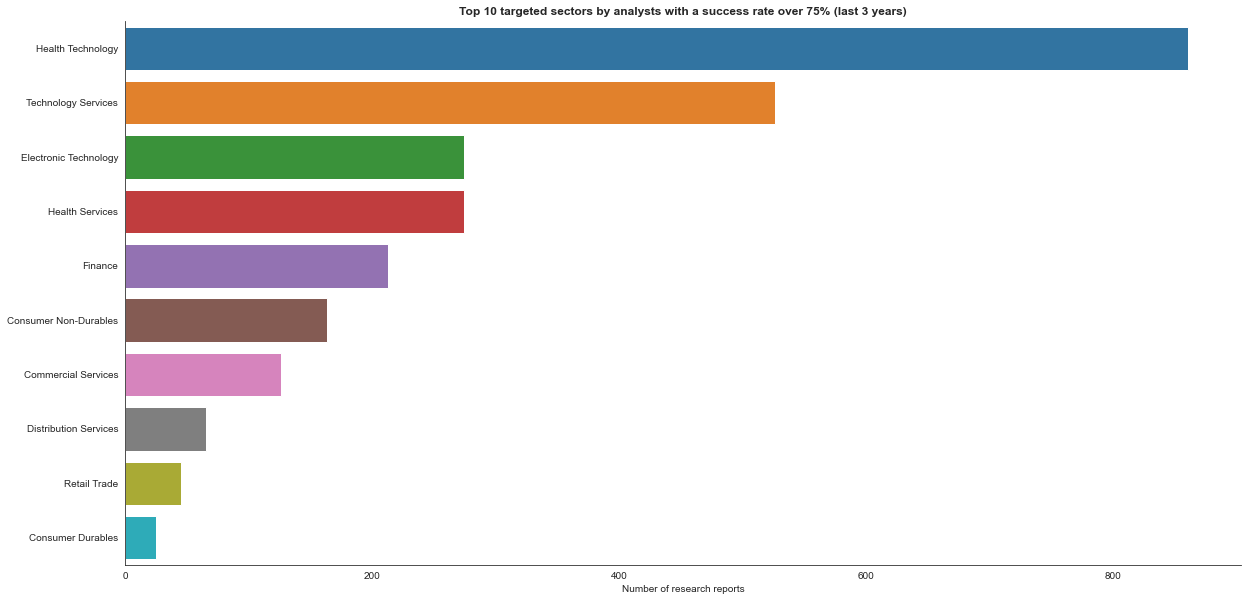

In [528]:
sector = recent_frame_over_75pc.sector.value_counts()[0:10] 
# plot targeted industries by analysts with a success rate over 75%
fig, ax = plt.subplots( figsize = (20,10))
sns.barplot(x = sector.values, y =  sector.index);
plt.title("Top 10 targeted sectors by analysts with a success rate over 75% (last 3 years)", fontweight = 'bold');
ax.set_xlabel('Number of research reports')
sns.despine()

### 8.2.3. Market capitalization classification

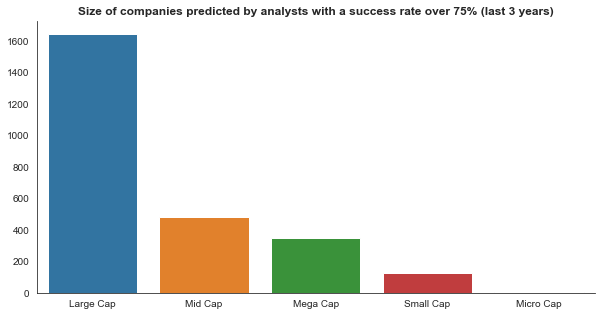

In [244]:
market_cap_classification = recent_frame_over_75pc.market_cap_classification.value_counts()[0:10] 
# plot targeted industries by analysts with a success rate over 75%
fig, ax = plt.subplots( figsize = (10,5))
sns.barplot(x = market_cap_classification.index, y =  market_cap_classification.values);
plt.title("Size of companies predicted by analysts with a success rate over 75% (last 3 years)", fontweight = 'bold');
sns.despine()

### 8.2.3 Country

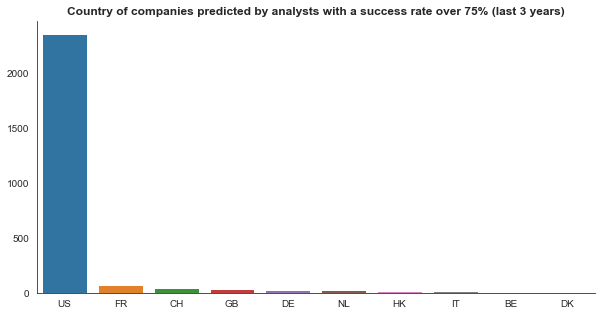

In [245]:
country = recent_frame_over_75pc.country.value_counts()[0:10] 
# plot targeted industries by analysts with a success rate over 75%
fig, ax = plt.subplots( figsize = (10,5))
sns.barplot(x = country.index, y =  country.values);
plt.title("Country of companies predicted by analysts with a success rate over 75% (last 3 years)", fontweight = 'bold');
sns.despine()

###### Joint plot - Country vs Market cpa size

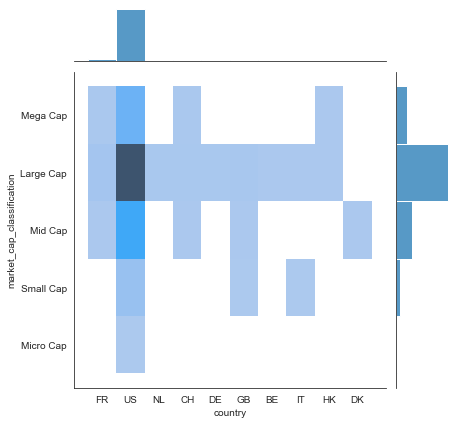

In [685]:
country_market = recent_frame_over_75pc[['country', 'market_cap_classification']]
sns.jointplot(data = country_market, x = 'country', y = 'market_cap_classification', kind="hist" );

The above plot visualised clearly the relation between country and market capitalization size in the top analysts' research reports

## 8.2.4. Clustering 

Clustering was used (again) to try and find similarities among the companies based on country, industry and market capitalization classification. 

In [455]:
clust_cat = recent_frame_over_75pc[['country', 'industry', 'market_cap_classification', 'prediction_result']] # selecting the columns to cluster
clust_cat = clust_cat.dropna() # dropping  null values

Below an elbow plot was used to understand what a good number of clusters could be:

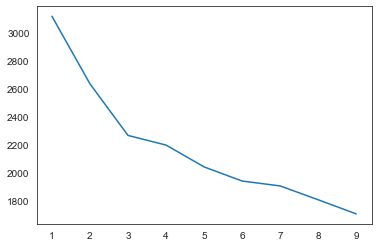

In [465]:
# calculating the optimal number of clusters
cost = []
for num_clusters in list(range(1,10)):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 10, verbose=0)
    kmode.fit_predict(clust_cat.iloc[:, 0:3])
    cost.append(kmode.cost_)
x = np.array([i for i in range(1,10,1)])
sns.lineplot(x = x, y = cost);

In [521]:
km = KModes(n_clusters = 3, init = 'Huang', n_init = 50, verbose = 0) # creating the model
fitClusters_huang = km.fit_predict(clust_cat.iloc[:, 0:3]) # fitting and predicting the clusters
mca = prince.MCA( n_components=2, n_iter=10, copy=True,  check_input=True, engine='auto', random_state=42) # setting the Multiple correspondence analysis (MCA)
mca = mca.fit(clust_cat) # fitting the MCA
mca_cor = mca.row_coordinates(clust_cat) # coordinated on reduced dimensions

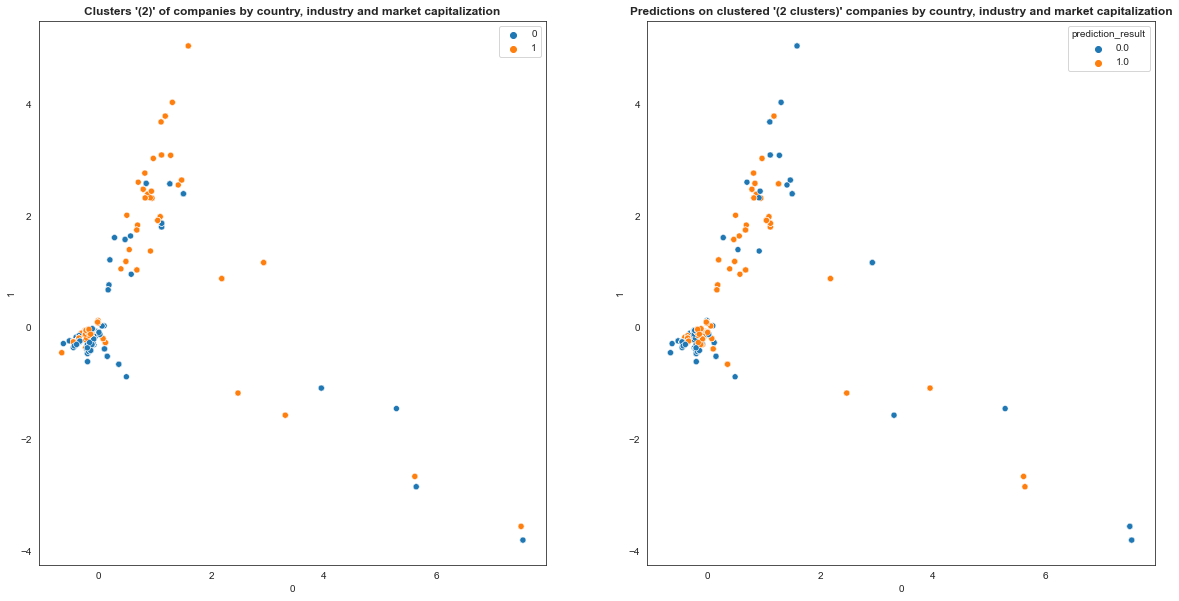

In [520]:
# plot the scaled dimensions and colors bases on previously calculated clusters
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
sns.scatterplot(ax = ax[0], x = mca_cor.iloc[:,0], y = mca_cor.iloc[:,1], hue = fitClusters_huang,  alpha = 1 );
ax[0].set_title("Clusters '(2)' of companies by country, industry and market capitalization", fontweight = 'bold');
# plot the scaled dimensions and colors bases on previously calculated clusters
sns.scatterplot( ax = ax[1], x = mca_cor.iloc[:,0], y = mca_cor.iloc[:,1], hue = clust_cat.prediction_result,  alpha = 1);
ax[1].set_title("Predictions on clustered '(2 clusters)' companies by country, industry and market capitalization", fontweight = 'bold');


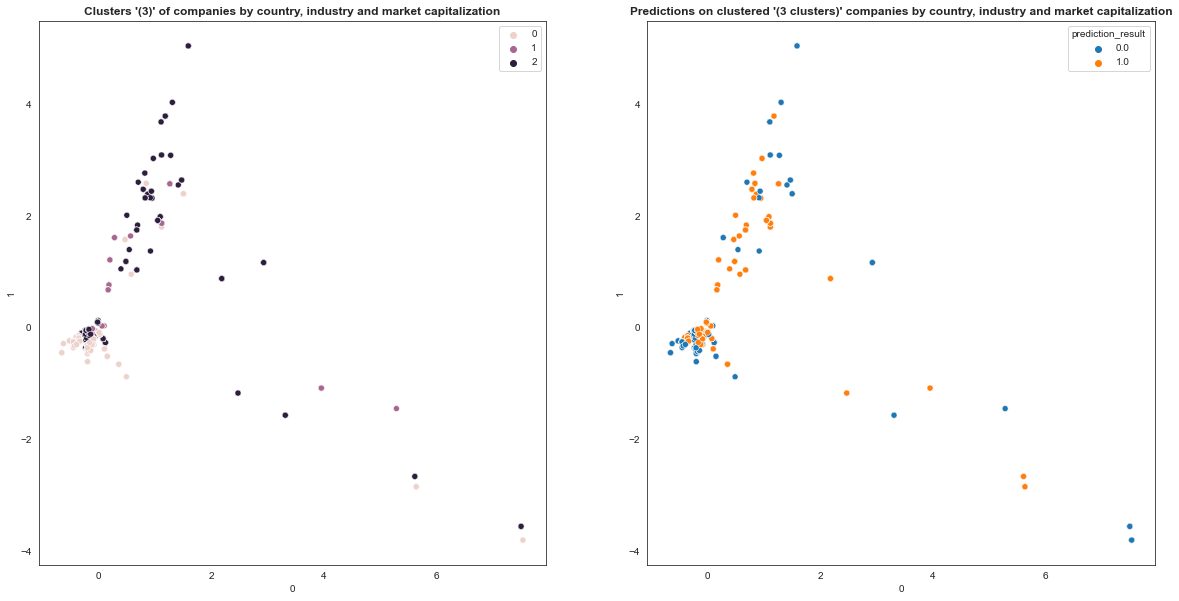

In [522]:
# plot the scaled dimensions and colors bases on previously calculated clusters
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
sns.scatterplot(ax = ax[0], x = mca_cor.iloc[:,0], y = mca_cor.iloc[:,1], hue = fitClusters_huang,  alpha = 1 );
ax[0].set_title("Clusters '(3)' of companies by country, industry and market capitalization", fontweight = 'bold');
# plot the scaled dimensions and colors bases on previously calculated clusters
sns.scatterplot( ax = ax[1], x = mca_cor.iloc[:,0], y = mca_cor.iloc[:,1], hue = clust_cat.prediction_result,  alpha = 1);
ax[1].set_title("Predictions on clustered '(3 clusters)' companies by country, industry and market capitalization", fontweight = 'bold');

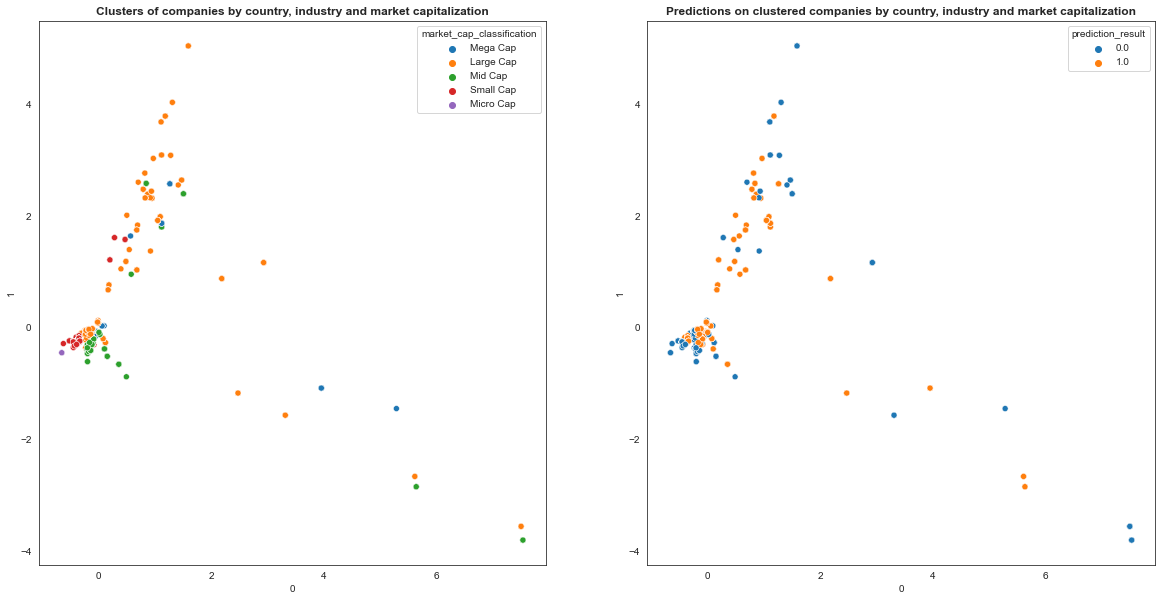

In [518]:
# plot the scaled dimensions and colors bases on market capitalization
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
sns.scatterplot(ax = ax[0], x = mca_cor.iloc[:,0], y = mca_cor.iloc[:,1], hue = clust_cat.market_cap_classification,  alpha = 1 );
ax[0].set_title("Clusters of companies by country, industry and market capitalization", fontweight = 'bold');
# plot the scaled dimensions and colors bases on previously calculated clusters
sns.scatterplot( ax = ax[1], x = mca_cor.iloc[:,0], y = mca_cor.iloc[:,1], hue = clust_cat.prediction_result,  alpha = 1);
ax[1].set_title("Predictions on clustered companies by country, industry and market capitalization", fontweight = 'bold');

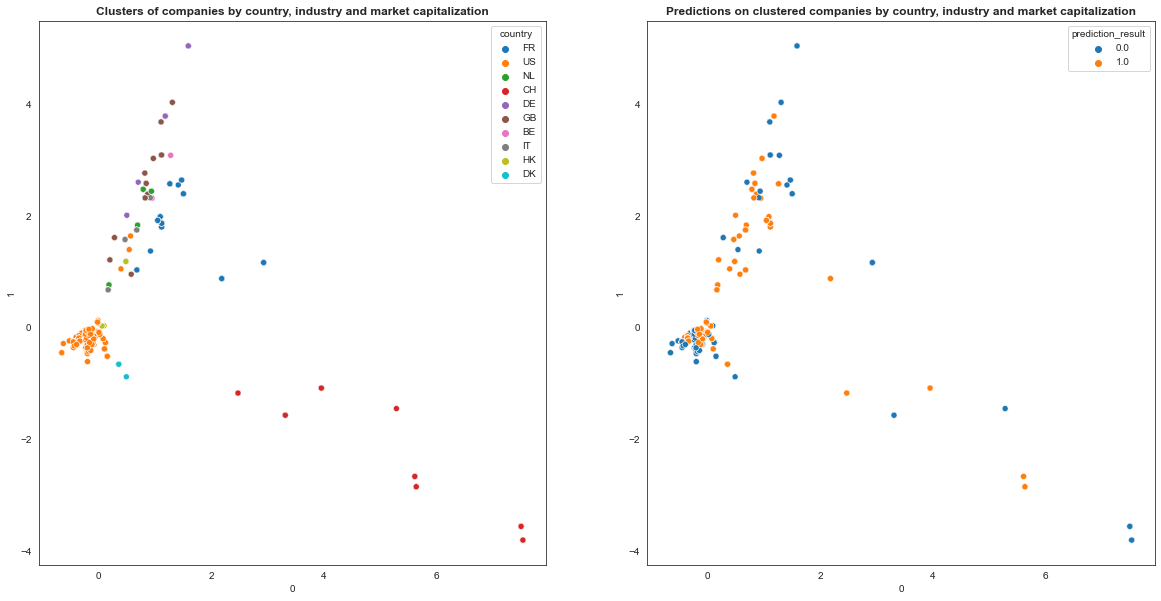

In [497]:
# plot the scaled dimensions and colors bases on country
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
sns.scatterplot(ax = ax[0], x = mca_cor.iloc[:,0], y = mca_cor.iloc[:,1], hue = clust_cat.country,  alpha = 1 );
ax[0].set_title("Clusters of companies by country, industry and market capitalization", fontweight = 'bold');
# plot the scaled dimensions and colors bases on previously calculated clusters
sns.scatterplot( ax = ax[1], x = mca_cor.iloc[:,0], y = mca_cor.iloc[:,1], hue = clust_cat.prediction_result,  alpha = 1);
ax[1].set_title("Predictions on clustered companies by country, industry and market capitalization", fontweight = 'bold');

Country was probabily the feature that explained the clusters the best, yet overall this analysis did not show any well defined clusters. 

## 8.2.5. Results

It was possible to find moderate correlation between industry, country, size of the company and research reports results published by the top analysts. <br>
The top analysts focused mostly on large cap, tech and medical companies, listed in the US. 
Most of the companies in the given data were from the US, that may explain the prevalence of US companies, but market capitalization size and especially sector/industry were very specific to these reports. 

## 8.3 Insight on ratings and providers

In [484]:
# select only right predictions
frame_right = recent_frame_over_75pc.loc[recent_frame_over_75pc.prediction_result == 1] 
# select only wrong predictions
frame_wrong = recent_frame_over_75pc.loc[recent_frame_over_75pc.prediction_result == 0] 

### 8.3.1. WordClouds

In [485]:
# clean and tokenize the research reports titles 
strings_right = [string for string in frame_right.research_report_title]
strings_right = "".join(strings_right)
strings_right = word_tokenize(strings_right)
strings_wrong = [string for string in frame_wrong.research_report_title]
strings_wrong = "".join(strings_wrong)
strings_wrong = word_tokenize(strings_wrong)

In [486]:
# stop words 
stop_words = ["Recap", "Review", "Solid", "Guidance","As", "Outlook", "as", "Growth", "Still", "Beat", "Inc", "But", "but", 'in', 'to', 'The', 'the', 'a', "A", 'an', 'as', "and", "Read", "First", "Neutral", "for", "on", "of", "Buy", "growth", "with", "Strong", "is", "line", "results", "Evidence", "2020", "guidance", "ubs", "2019", "19"]
strings_right_cl = [s for s in strings_right if not s in stop_words]
strings_wrong_cl = [s for s in strings_wrong if not s in stop_words]

In [489]:
# tried everything to remove the apostrophes in the WorldCloud (there's none left in strings_wrong_cl) but no success.
strings_wrong_cl = ([s.replace("' '", " ") for s in strings_wrong_cl])
strings_wrong_cl = ([s.replace("`", " ") for s in strings_wrong_cl])
strings_wrong_cl = ([s.replace("'", " ") for s in strings_wrong_cl])
strings_wrong_cl = ([s.replace(" '", " ") for s in strings_wrong_cl])
strings_wrong_cl = ([s.replace("``", " ") for s in strings_wrong_cl])
strings_wrong_cl = ([s.replace("''", " ") for s in strings_wrong_cl])
strings_wrong_cl = ([s.strip("'") for s in strings_wrong_cl])
strings_wrong_cl = ([s.strip() for s in strings_wrong_cl])

Plot of the WordCloud image of the words in the titles of the research reports resulted in a right prediction:

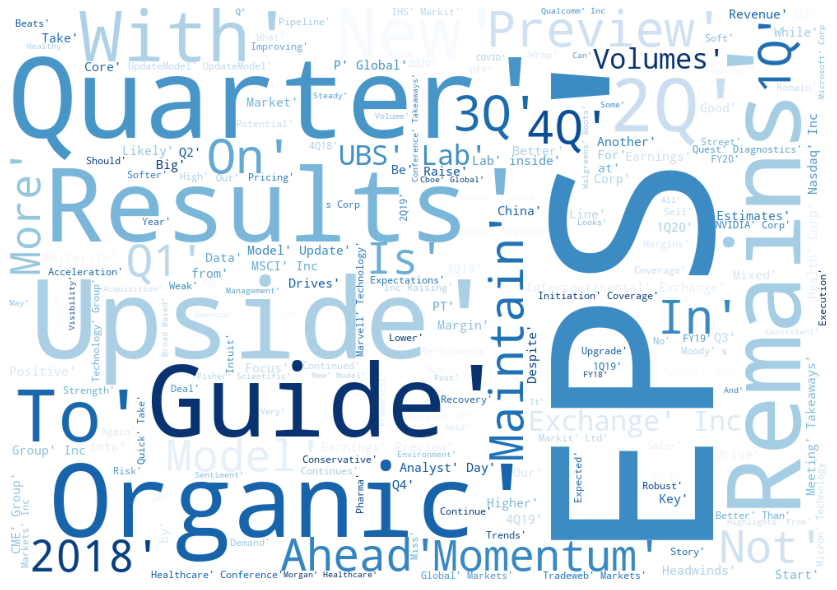

In [490]:
wordcloud = WordCloud(width = 1000, height = 700, background_color ='white', colormap= 'Blues', min_font_size = 10).generate(str(strings_right_cl))
# plot the WordCloud image of the words in the titles of the researches resulted in a right predictions
plt.figure(figsize = (16, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

Plot of the WordCloud image of the words in the titles of the research reports resulted in a wrong prediction:

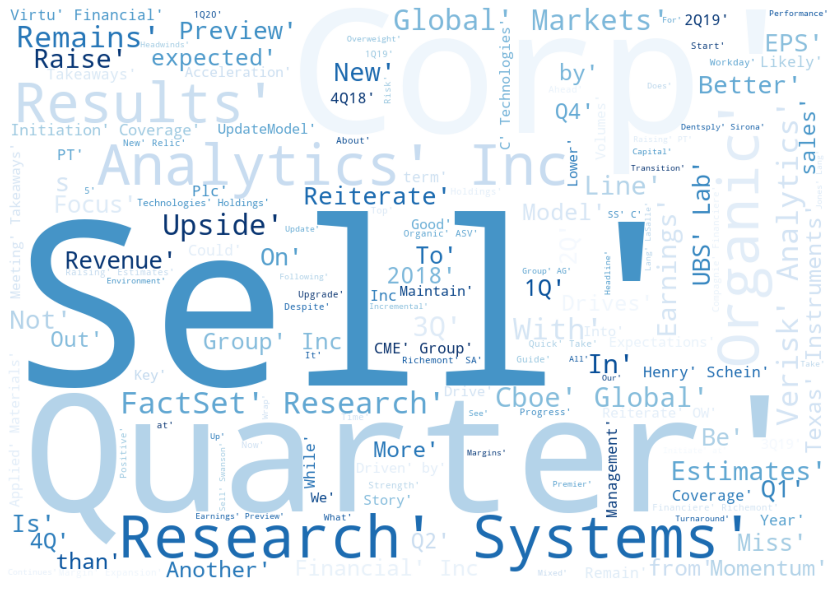

In [151]:
wordcloud = WordCloud(width = 1000, height = 700, background_color ='white', colormap= 'Blues', min_font_size = 10).generate(str(strings_wrong_cl))
# plot the WordCloud image of the words in the titles of the researches resulted in a wrong predictions
plt.figure(figsize = (16, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

The above WordClouds were very useful to indentify one peculiarity of the correct predictions: they very rarely showed the word "sell", differently from the wrong predictions. 

### 8.3.2. Ratings 

Below it was checked how the types of ratings vary between right and wrong predictions (made by the top analysts):

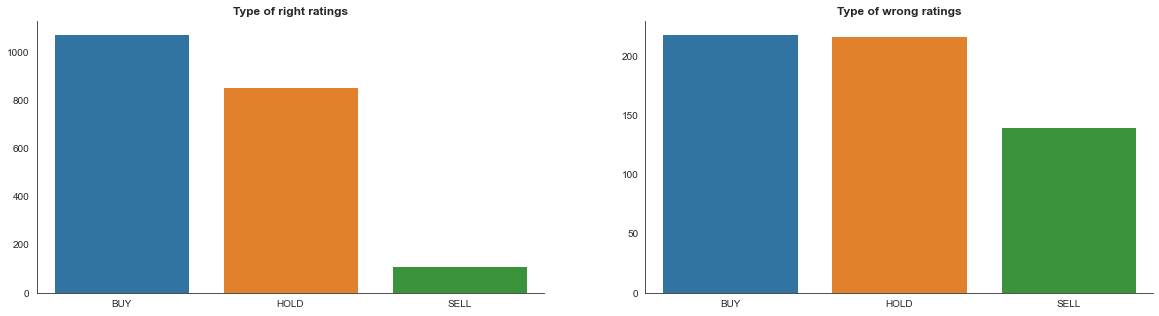

In [249]:
rating_r = frame_right.research_rating.value_counts()
rating_w = frame_wrong.research_rating.value_counts()
# all type of right ratings given by the best analysts
fig, ax = plt.subplots(1,2, figsize = (20,5))
sns.barplot(x = rating_r.index, y =  rating_r.values, ax = ax[0]);
sns.barplot(x = rating_w.index, y =  rating_w.values, ax = ax[1]);
sns.despine()
ax[0].set_title("Type of right ratings", fontweight = 'bold')
ax[1].set_title("Type of wrong ratings", fontweight = 'bold');

### 8.3.3. Providers

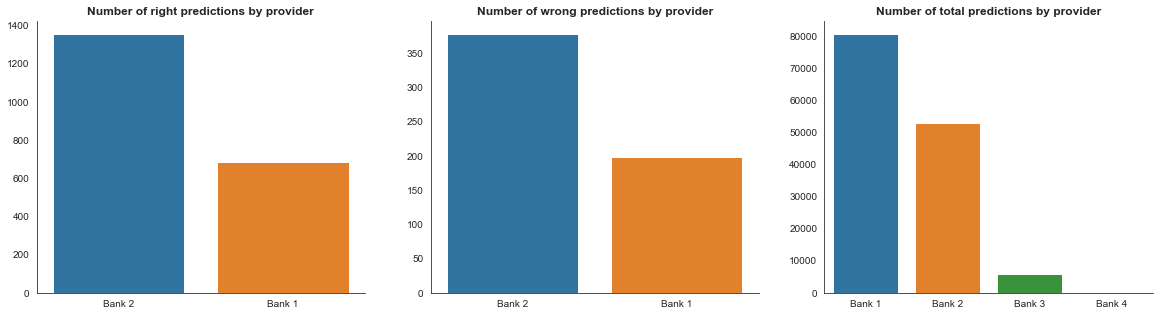

In [250]:
providers_r = frame_right.research_provider_id.value_counts()
providers_w = frame_wrong.research_provider_id.value_counts()
# all type of right ratings given by the best analysts
fig, ax = plt.subplots(1,3, figsize = (20,5))
sns.barplot(x = providers_r.index, y =  providers_r.values, ax = ax[0]);
sns.barplot(x = providers_w.index, y =  providers_w.values, ax = ax[1]);
sns.barplot(x = frame.research_provider_id.value_counts().index, y =  frame.research_provider_id.value_counts().values, ax = ax[2]);
sns.despine()
ax[0].set_title("Number of right predictions by provider", fontweight = 'bold')
ax[1].set_title("Number of wrong predictions by provider", fontweight = 'bold');
ax[2].set_title("Number of total predictions by provider", fontweight = 'bold');

The top authors came from 2 different banks (out of the 4 present in the data), with a prevalance of bank 2, despite this was not the prevalent bank in the original dataset.

## 8.3.4. Results

The right predictions, together with being focused on the Health and Technology sectors, focused on the US market and large size companies. They mostly came from Bank 2 and recommend buying or holding, rather than selling. 

## 8.4 Question 4: Is there any correlation between ESG values and analysts’ ratings ?


## 8.4.1. Boxplots and colormpas 

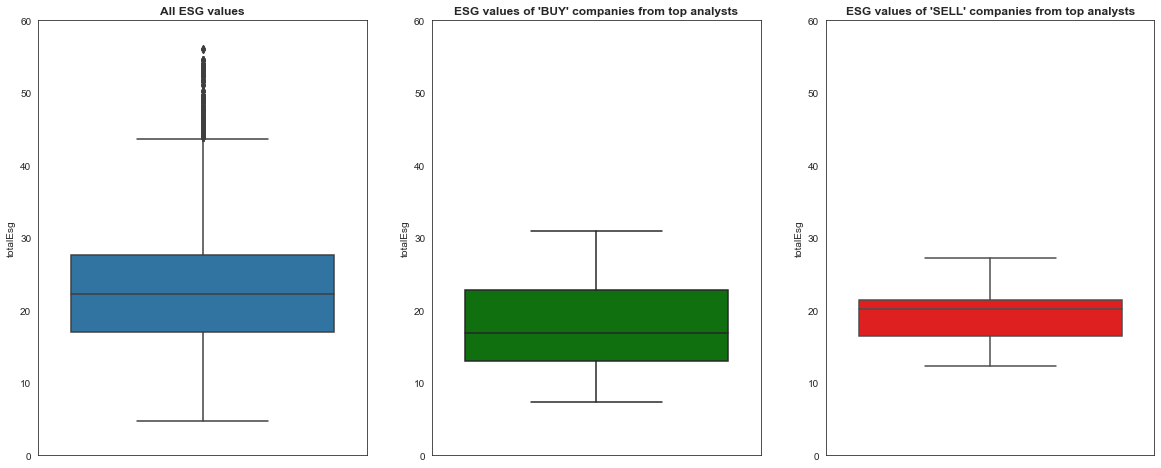

In [251]:
# boxplots of ESG risk scores (all companies in the data, top analysts' buy and top analysts' sell)
fig, ax = plt.subplots(1,3, figsize = (20,8))
sns.boxplot(y = frame.totalEsg, ax = ax[0]);
sns.boxplot(y = recent_frame_over_75pc.loc[recent_frame_over_75pc['research_rating'] == 'BUY', 'totalEsg'], ax = ax[1], color= 'green')
sns.boxplot(y = recent_frame_over_75pc.loc[recent_frame_over_75pc['research_rating'] == 'SELL', 'totalEsg'], ax = ax[2], color= 'red');
ax[0].set(ylim=(0, 60)); ax[1].set(ylim=(0, 60)); ax[2].set(ylim=(0, 60));
ax[0].set_title("All ESG values", fontweight = 'bold')
ax[1].set_title("ESG values of 'BUY' companies from top analysts", fontweight = 'bold');
ax[2].set_title("ESG values of 'SELL' companies from top analysts", fontweight = 'bold');

Top analysts recommended to buy companies with lower ESG risk scores than the total average and, among the companies they researched, the ones they recommend to sell had slightly higher ESG risk scores. 

In [373]:
# select the mean ESG values by year from the general frame, and the top analysts recommendations to buy and sell (in the last 3 years)
esg_buy_by_year = recent_frame_over_75pc.loc[recent_frame_over_75pc['research_rating'] == 'BUY'].resample('Y')['totalEsg'].mean().dropna() 
esg_sell_by_year = recent_frame_over_75pc.loc[recent_frame_over_75pc['research_rating'] == 'SELL'].resample('Y')['totalEsg'].mean() 
last3year_frame = frame['2018-10-01' : '2021-09-01']
esg_tot_by_year = last3year_frame.resample('Y')['totalEsg'].mean() 

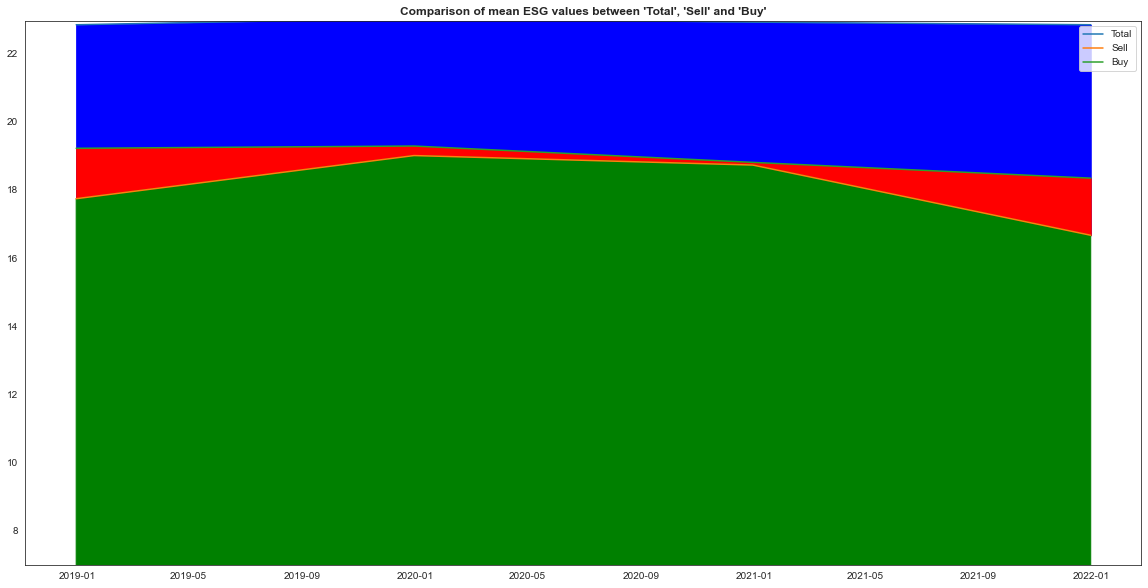

In [371]:
#color maps to fill between 
col_map = esg_buy_by_year - esg_sell_by_year
col_pos = col_map >= 0
col_neg = col_map < 0
#plots
plt.figure(figsize = (20,10))
plt.plot(esg_tot_by_year.index, esg_tot_by_year .values)
plt.plot(esg_buy_by_year.index, esg_buy_by_year.values)
plt.plot(esg_sell_by_year.index, esg_sell_by_year.values)
plt.fill_between(esg_tot_by_year.index, esg_tot_by_year.values, esg_buy_by_year.values, where = col_neg,  color = 'blue', interpolate = False)
plt.fill_between(esg_sell_by_year.index, esg_sell_by_year.values, esg_buy_by_year.values, where = col_neg,  color = 'red', interpolate = False);
plt.fill_between(esg_buy_by_year.index, esg_buy_by_year.values,  color = 'green', interpolate = False);
plt.legend(["Total", "Sell", "Buy"]);
plt.ylim(recent_frame_over_75pc.totalEsg.min(), last3year_frame.totalEsg.mean())
plt.title("Comparison of mean ESG values between 'Total', 'Sell' and 'Buy'", fontweight = 'bold');

The above plots showed differences in ESG values, but how significant were they? 

## 8.4.2. Effect size - Cohen's d 

In [551]:
rec_frame = frame['2018-10-01' : '2021-09-01'] # last 3 years from the original frame 
# last 3 years from the top analysts (only "BUY" ratings)
rec_fr_buy = recent_frame_over_75pc.loc[recent_frame_over_75pc['research_rating'] == 'BUY'] 
# last 3 years from the top analysts (only "SELL" ratings)
rec_fr_sell = recent_frame_over_75pc.loc[recent_frame_over_75pc['research_rating'] == 'SELL']

In [560]:
#Cohen's d on ESG values between top analysts' buy and sell companies 
# code re-arranged from lab feedback 4 (there may be an oversight in s1 of that lab's code)
n1=rec_fr_buy.totalEsg.count()
n2=rec_fr_sell.totalEsg.count()
s1=rec_fr_buy.totalEsg.var()
s2=rec_fr_sell.totalEsg.var()
s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2 / (n1 + n2 - 2)))

u1=rec_fr_buy.totalEsg.mean()
u2=rec_fr_sell.totalEsg.mean()

d = (u1 - u2) / s
d

-0.0025841370460811287

In [557]:
#Cohen's d on ESG values between top analysts' buy companies and total companies in the data
# code re-arranged from lab lab feedback 4
n1=rec_fr_buy.totalEsg.count()
n2=rec_frame.totalEsg.count()
s1=rec_fr_buy.totalEsg.var()
s2=rec_frame.totalEsg.var()
s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2 / (n1 + n2 - 2)))

u1=rec_fr_buy.totalEsg.mean()
u2=rec_frame.totalEsg.mean()

d = (u1 - u2) / s
d

-0.025029149888119252

The above effect sizes suggested a not significant difference between the ESG means of "buy" and "sell" from the top analysts and "total", when compared to the variation in the data. 
(The negative values signaled that the mean of the recommended "buy" companies were smaller than the means of recommended "sell" and all the other ESG scores).  

## 8.4.3 Results 

Top analysts recommended to buy companies with lower ESG risk scores but the differences in means were statistically insignificant.  

## 8.5 Question 4: Are forecasts influenced by specific external events?

To answer this question it was studied how the analysts' forecasts' accuracy changed over time, compared to a market index (SP500) known for reflecting the market and the main external events that have in impact on it.

## 8.5.1. Work with Time Series

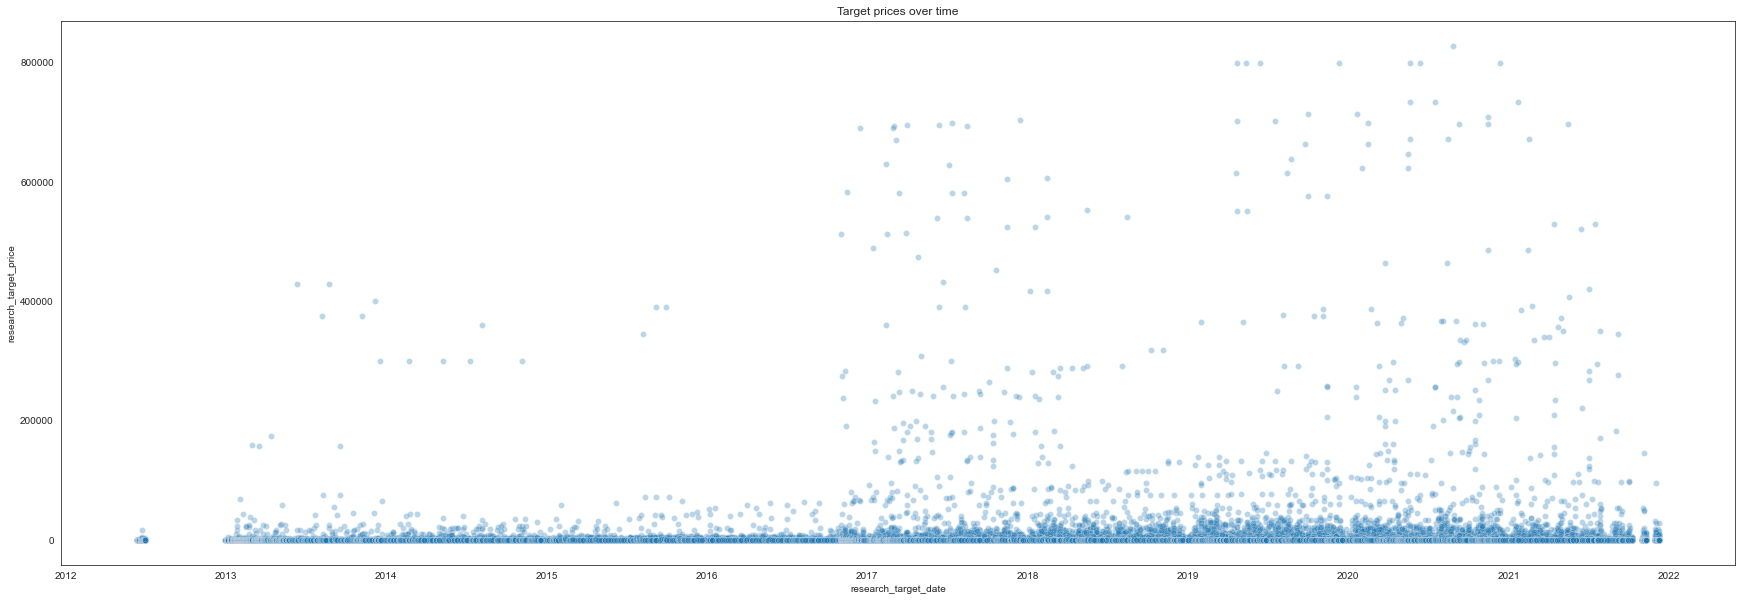

In [380]:
predictions_by_year = frame.resample('Y')['prediction_result'].count()  # number of predictions made by year
right_predictions_by_year = frame.resample('Y')['prediction_result'].sum()  # number of right predictions made by year
predictions_by_month = frame.resample('M')['prediction_result'].count()  # number of predictions made by month
right_predictions_by_month = frame.resample('M')['prediction_result'].sum()  # number of right predictions made by month
monthly_prediction_ratio = right_predictions_by_month.values / predictions_by_month.values  # percentage of right predictions made by month
fig, ax = plt.subplots( figsize = (30,10));
sns.scatterplot(x=frame.research_publish_date.index, y=frame.research_target_price, alpha=0.3);
plt.title('Target prices over time');

In [383]:
yfticker = yf.download('^GSPC', start = '2012-06-12', end = '2021-10-01') # scrapes SP500 close values. Original source: https://github.com/ranaroussi/yfinance   

[*********************100%***********************]  1 of 1 completed


In [384]:
yfticker_by_month = yfticker.resample('M')['Close'].mean()  #resamples the SP500 by month

In [386]:
top75_predictions_by_year = frame_over_75pc.resample('Y')['prediction_result'].count()  # number of predictions made by year
top75_right_predictions_by_year = frame_over_75pc.resample('Y')['prediction_result'].sum()  # number of right predictions made by year
top75_predictions_by_month = frame_over_75pc.resample('M')['prediction_result'].count()  # number of predictions made by month
top75_right_predictions_by_month = frame_over_75pc.resample('M')['prediction_result'].sum()  # number of right predictions made by month
top75_monthly_prediction_ratio = top75_right_predictions_by_month.values / top75_predictions_by_month.values  # percentage of right predictions made by month

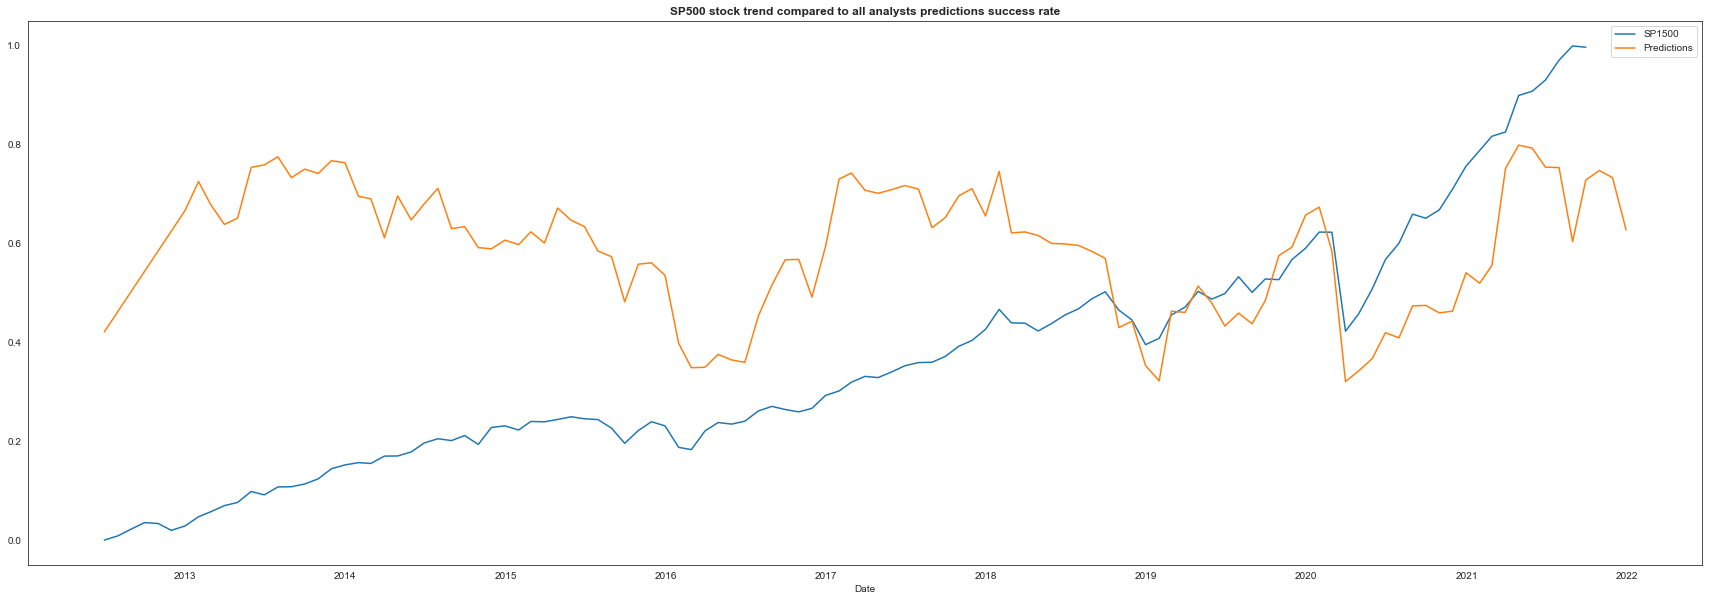

In [682]:
# plot normalized SP500 vs all-analysts'predictions success rate
fig, ax = plt.subplots( figsize = (30,10));
norm_sp500 = (yfticker_by_month.values - yfticker_by_month.values.min())/(yfticker_by_month.values.max() -yfticker_by_month.values.min()) # normalized sp1500
sns.lineplot(x = yfticker_by_month.index, y = norm_sp500 , label = 'SP1500'); # plots normalized sp500
sns.lineplot(x=predictions_by_month.index, y=monthly_prediction_ratio, label = 'Predictions'); # plots right predictions %
plt.title("SP500 stock trend compared to all analysts predictions success rate", fontweight = 'bold');
plt.legend(); 

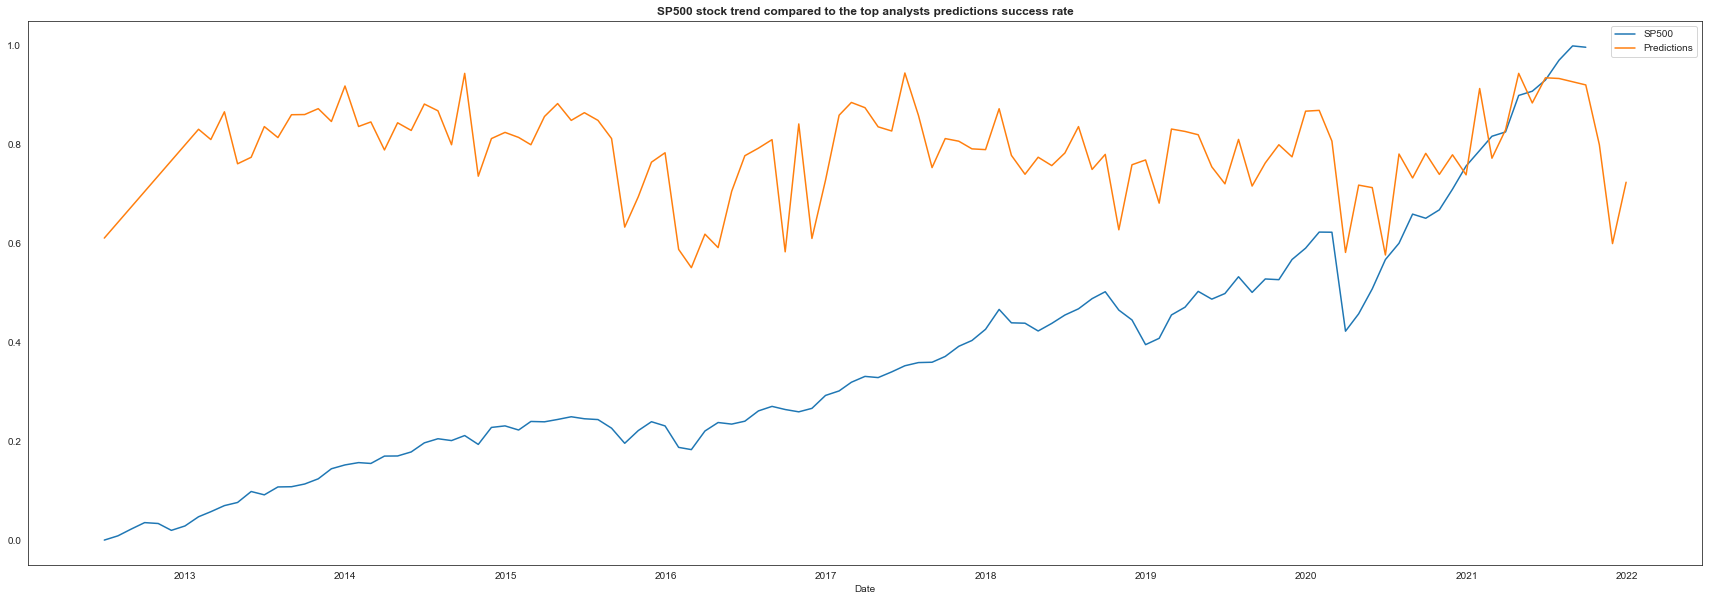

In [683]:
# plot normalized SP500 vs top analysts' success rate
fig, ax = plt.subplots( figsize = (30,10));
sns.lineplot(x = yfticker_by_month.index, y = norm_sp500 , label = 'SP500'); # plots normalized sp1500
sns.lineplot(x=top75_predictions_by_month.index, y=top75_monthly_prediction_ratio, label = 'Predictions'); # plots right predictions %
plt.title("SP500 stock trend compared to the top analysts predictions success rate", fontweight = 'bold');
plt.legend();

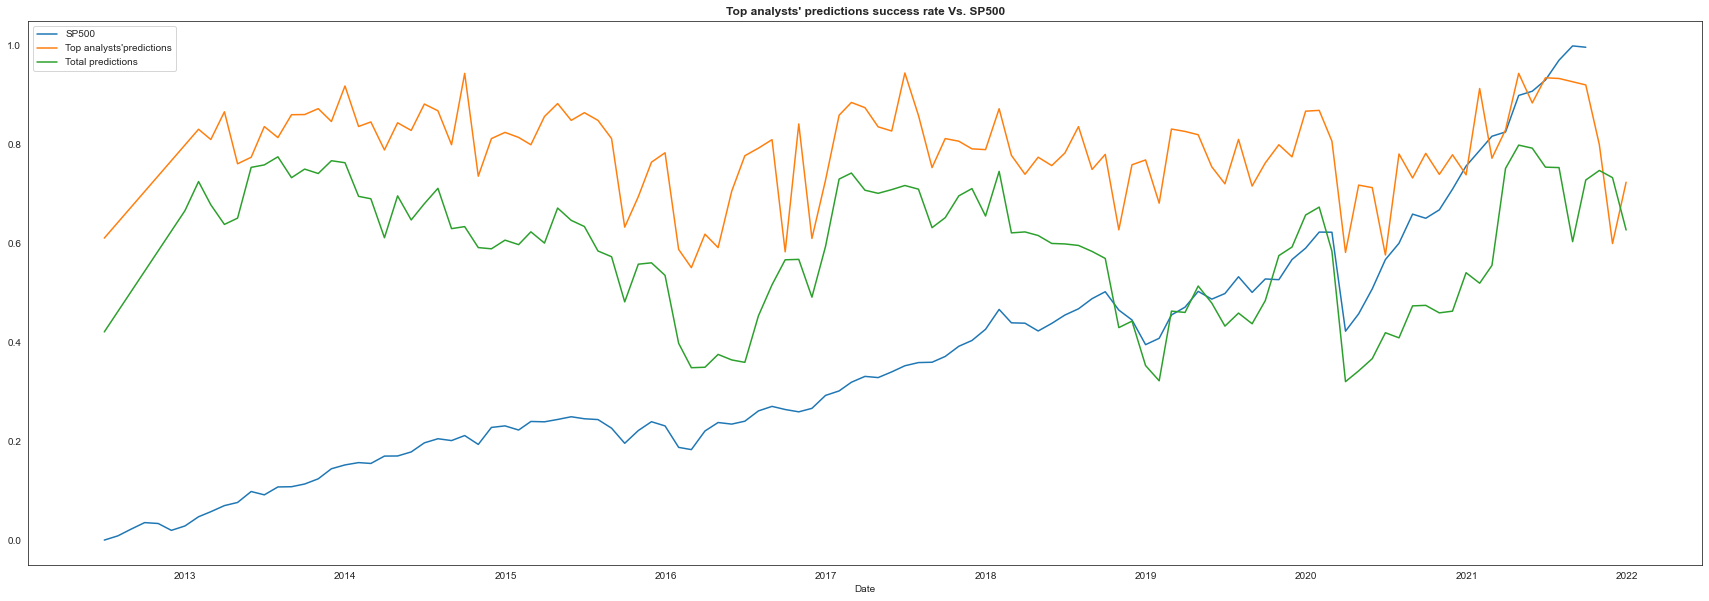

In [530]:
# plot normalized SP500 vs top analysts' and all-analysts' success rate
fig, ax = plt.subplots( figsize = (30,10));
sns.lineplot(x = yfticker_by_month.index, y = norm_sp500 , label = 'SP500'); # plots normalized sp1500
sns.lineplot(x=top75_predictions_by_month.index, y=top75_monthly_prediction_ratio, label = "Top analysts'predictions"); # plots right predictions %
sns.lineplot(x=predictions_by_month.index, y=monthly_prediction_ratio, label = 'Total predictions'); # plots right predictions %
plt.title("Top analysts' predictions' success rate Vs. SP500", fontweight = 'bold');
plt.legend();

## 8.5.2 Results


External macro-events seemed to have an important impact on forecasts’ accuracy, with big swings in the market resulting in an average deterioration of analysts’ performance of around 20%. All the analysts “suffered” the stock market crises (2016, 2019, 2020), with their prediction accuracy dropping each time the market plunged. 
Although the top analysts’ accuracy was consistently higher, this pattern of worse performance during market sell off was still observed.
All the analysts achieved their best prediction rates during bull markets that demonstrated consistent upward price moves.


#  9. Conclusions

## 9.1. Final conclusions 

It was possible to identify fifteen analysts who, in the last three years, made between 50 and 427 predictions with a
success rate equal to or greater than 75%. 
66.3% of  these top analysts’ research reports were published by Bank 2 and 33.7% by Bank 1. 
50% of their research reports recommended to buy,  40% to hold an only 10% to sell. 
Their recommendations focused on large capitalization size companies (63%), predominantly based in the US (90%)  and operating in the Health and Technological sectors (aggregated: 74%).
The top performing analysts’ accuracy fluctuated between 60% and 90%, with a mean of 78%, with peaks during consistent upward market trends and lows during market crisis. 
There was not statistically significant difference between the ESG risk scores of recommended “buy” companies and the average company in the data. 
The name of the top performing analysts and of the 136 companies they recommend to buy were identified.


## 9.2. Future work

Further improvements in the tickers’ mapping and manual labeling of the remaining ones would have avoided significant data loss and would be advisable to more in-depth analysis.   
Likewise, more in-depth work on the outliers could likely recover a significant amount of data.
The dataset lends itself to be augmented with additional features on companies’ references and particularly external
events. World events, important announcements, inflation and interest rates would broaden the range of the analysis and likely lead to the discovery of meaningful patterns that were overlooked in this study. These features would also work towards building a machine learning forecasting model. 
Scraping data from Yahoo Finance was an effective way to augment the dataset but it turned out to be very slow due to the Yahoo Query Language (YQL) public API capping the requests at 2.000/hour and blocking large volumes of synchronized requests. YQL private API (with OAuth authentication) would have raised that limit to 20.000 requests/hour and allowed multithreading requests to reduce the scraping times drastically. 
Finally, focusing the study on specific subsets (i.e, times or industries) would allow more granular findings on topics of particular interest. 
